In [3]:
from Bio import AlignIO
from Bio import SeqIO
from Bio.Seq import Seq
import csv
import baltic as bt
import collections
# from Bio.Alphabet import IUPAC
# from pySankey.sankey import sankey
import math
import collections
import os
import csv
from Bio import SeqIO
import os
import matplotlib as mpl
from matplotlib import pyplot as plt
import seaborn as sns
import collections
import numpy as np
import pandas as pd
import datetime
from datetime import date
import skbio
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.path as mpath
import matplotlib.lines as mlines
import collections
import matplotlib.patches as patches
import matplotlib.colors as mcolors
from matplotlib.patches import Polygon
from matplotlib import cm
# from matplotlib.colors import ListedColormap, LinearSegmentedColormap

# from matplotlib.collections import PatchCollection
from epiweeks import Week, Year
font = {'family' : 'Helvetica',
        'weight' : 'bold',
        'size'   : 18}
from matplotlib.lines import Line2D

mpl.rcParams.update({'font.size': 18})

new_rc_params = {'text.usetex': False,
"svg.fonttype": 'none'
}
mpl.rcParams.update(new_rc_params)

## TOC:
* [Reconstruction functions](#reconstruction)
* [Synonymous finder functions](#synonymous)
* [AA category figure functions](#aacategory)
* [Smallpox analysis](#smallpox)
* [Clade1](#clade1)
* [Clade2](#clade2)
* [CDS dataset: variola](#variolacds)
* [CDS dataset: all pox](#allpoxcds)
* [Heptamer analysis](#heptamer)
* [Root to tip analysis](#roottotip)

## Reconstruction functions <a class="anchor" id="reconstruction"></a>


squirrel hMPXV_2022-06-09_101_genomes.fasta 

iqtree -asr 
-s hMPXV_2022-06-09_101_genomes.aln.fasta 
-o "KJ642615|W-Nigeria|Nigeria|1978" 
-czb 
-m JC 
&& cp hMPXV_2022-06-09_101_genomes.aln.fasta.treefile hMPXV_2022-06-09_101_genomes.fasta.tree 

jclusterfunk prune -i hMPXV_2022-06-09_101_genomes.fasta.tree  -o hMPXV_2022-06-09_101_genomes.fasta.pruned.tree -t "KJ642615|W-Nigeria|Nigeria|1978"


In [2]:

    
    
def get_node_states_all_sites(directory,state_file,alignment):
    
    #returns a dict keys off 1-based positions in the genome
    #and the value is a list of tuples (id, base) at a given node
    # allows you to look up for a given site what the base is for a
    #given internal node or tip
    
    node_states = collections.defaultdict(list)
    c = 0
    
    ## first the reconstructed nodes
    with open(f"{directory}/{state_file}","r") as f:
        for l in f:

            if not l.startswith("#"):
                c+=1
                try:
                    node,site,state,probA,probC,probG,probT = l.rstrip("\n").split("\t")
                except:
                    print(l)
                    break
                if node != "Node":
                    if state not in ["N","-"]:
                        node_states[site].append((node,state))
                    else:
                        node_states[site].append((node,""))
    ## now the tips
    for record in SeqIO.parse(f"{directory}/{alignment}","fasta"):
        for site in node_states:
            index = int(site)-1
            base = record.seq[index]
            if base in ["T","C","A","G"]:
                node_states[site].append((record.id,base))
            else:
                node_states[site].append((record.id,""))
                
    return node_states

def get_header_str(dict_values):
    header_str = ""
    for i in sorted(dict_values, key = lambda i : i[0]):
        header_str += f"{i[0]},"
    header_str = header_str.rstrip(",")
    return header_str
    
    
def find_what_sites_vary_unambiguously(node_states,outfile):
    header_str = get_header_str(node_states["1"])
    
    with open(outfile,"w") as fw:
        fw.write(f"site,{header_str}\n")

        for site in node_states:
            info = node_states[site]
            
            # get the set of unique bases at a given site
            count = set([i[1] for i in info if i[1]])
            
            #if there's more than one
            if len(count)>1:
                
                #needs to be kep consistent with header str
                info = sorted(info, key = lambda i : i[0])
                base_str = ""
                for i in info:
                    base_str += f"{i[1]},"
                    
                base_str = base_str.rstrip(",")
                fw.write(f"{site},{base_str}\n")
    
def load_unambiguous_varying_sites(infile):
    node_states_diff = collections.defaultdict(dict)
    with open(infile,"r") as f:
        reader = csv.DictReader(f)
        for row in reader:
            site = row["site"]
            for col in row:
                if col != "site":
                    node_states_diff[row["site"]][col] = row[col]
    return node_states_diff

def map_site_changes_to_branches(treefile, outfile,node_states,node_states_diff): 
    my_tree=bt.loadNewick(treefile,absoluteTime=False)
    last_node = ""
    current_node = ""

    with open(outfile,"w") as fw:
        fw.write("parent,child,site,snp,dimer\n")

        for k in my_tree.Objects:
            if k.branchType == 'leaf':
                current_node = k
                current_node.traits["label"]=k.name
            else:
                current_node = k

            if last_node:
                node_name = current_node.traits["label"]
                parent_name = current_node.parent.traits["label"]
                snps = []
                for site in node_states_diff:
                    node_base = node_states_diff[site][node_name]
                    parent_base = node_states_diff[site][parent_name]

                    if node_base != parent_base:
                        if node_base in ["A","C","G","T"] and parent_base in ["A","C","G","T"]:
                            snp = f"{parent_base}->{node_base}"
                            snps.append(snp)
                            if snp == "G->A":
                                dimer_site = f"{int(site)+1}"
                                dimer_base = ""

                                for i in node_states[dimer_site]:
                                    if i[0] == parent_name:
                                        dimer_base = i[1]
                                dimer = f"{parent_base}{dimer_base}"
                            elif snp == "C->T":
                                dimer_site = f"{int(site)-1}"
                                dimer_base = ""

                                for i in node_states[dimer_site]:
                                    if i[0] == parent_name:
                                        dimer_base = i[1]
                                dimer = f"{dimer_base}{parent_base}"
                            else:
                                dimer = ""
                            fw.write(f"{parent_name},{node_name},{site},{snp},{dimer}\n")

            last_node = current_node

def read_in_branch_snps(branch_snps):
    branch_snps_dict = collections.defaultdict(list)
    with open(branch_snps,"r") as f:
        reader = csv.DictReader(f)
        for row in reader:
            branch = f"{row['parent']}_{row['child']}"
            branch_snps_dict[branch].append((row['site'],row['snp'],row['dimer'])) 
    return branch_snps_dict

def get_branch_snps_sites(branch_snps):
    branch_snps_dict = {}
    with open(branch_snps,"r") as f:
        reader = csv.DictReader(f)
        for row in reader:
            if row["site"] in branch_snps_dict:
                print("Duplicate mutation", row["site"])
            branch_snps_dict[int(row['site'])]=(row['parent'],row['child'],row['snp'],row['dimer'])
    return branch_snps_dict
    

def get_acc_to_metadata_map(metadata):
    acc_dict = {}
    with open(metadata,"r") as f:
        reader = csv.DictReader(f)
        for row in reader:
            try:
                acc_dict[row["accession"]] = row
            except:
                try:
                    acc_dict[row["\ufeffaccession"]] = row
                except:
                    pass
                
    return acc_dict

def make_reconstruction_tree_figure(outfile,branch_snps,treefile,width=25):
    
    branch_snps_dict = read_in_branch_snps(branch_snps)
    print(len(branch_snps_dict),"snps")
#     acc_dict = get_acc_to_metadata_map(metadata)
#     print(len(acc_dict))        
    
    my_tree=bt.loadNewick(treefile,absoluteTime=False)

    fig,ax = plt.subplots(figsize=(width,25),facecolor='w')

    x_attr=lambda k: k.height ## x coordinate of branches will be absoluteTime attribute
    su_func=lambda k: 50-30*k.height/my_tree.treeHeight ## size of tips
    s_func=lambda k: 50-20*k.height/my_tree.treeHeight ## size of tips
    c_func=lambda k: "dimgrey"

    increment = my_tree.treeHeight/150
    my_tree.plotTree(ax,x_attr=x_attr) ## plot branches
    my_tree.plotPoints(ax,size=s_func,colour=c_func,x_attr=x_attr) ## plot circles at tips
    mpl.rcParams['font.family'] = 'sans-serif'

    for k in my_tree.Objects:
        current_node = k
        if k.branchType == 'leaf':
            current_node.traits["label"]=k.name

        node_name = current_node.traits["label"]
        try:
            parent_name = current_node.parent.traits["label"]
        except:
            continue
        branch_name= f"{parent_name}_{node_name}"

        if branch_name in branch_snps_dict:
            snps = []
#                 print(branch_name, len(branch_snps_dict[branch_name]))
            snp_placement = current_node.parent.height + increment
            for s in branch_snps_dict[branch_name]:
                site,snp,dimer = s
                if snp == "G->A":
                    if dimer in ["GA"]:
                        snps.append((1,"orange"))
                    else:
                        snps.append((3,"lightseagreen"))
                elif snp == "C->T":
                    if dimer in ["TC"]:
                        snps.append((2,"blue"))
                    else:
                        snps.append((3,"lightseagreen"))
                else:
                    snps.append((4,"dimgrey"))

            for snp in sorted(snps, key = lambda x : x[0]):
                plt.scatter([snp_placement],[k.y+0.5],color=snp[1],s=30)
                snp_placement += increment

    [ax.spines[loc].set_visible(False) for loc in ['top','right','left','bottom']]
    ax.tick_params(axis='y',size=0)
    ax.tick_params(axis='x',size=0)

    ax.set_yticklabels([])
    ax.set_xticklabels([])

    plt.savefig(f"figures/{outfile}.svg");
    plt.savefig(f"figures/{outfile}.png",bbox_inches='tight', 
                   transparent=True);
    plt.show()

def generate_reconstruction_files(directory, alignment,treefile):
    
    node_states = get_node_states_all_sites(directory,f"{alignment}.state",alignment)
        
    find_what_sites_vary_unambiguously(node_states,f"{directory}/{treefile}.state_differences.csv")
    
def load_info(directory, alignment,treefile,treefigureout,width=35):
    node_states = get_node_states_all_sites(directory,f"{alignment}.state",alignment)
    node_states_diff = load_unambiguous_varying_sites(f"{directory}/{treefile}.state_differences.csv")

    map_site_changes_to_branches(f"{directory}/{treefile}",
                                 f"{directory}/{treefile}.branch_snps.reconstruction.csv",
                                 node_states,
                                 node_states_diff)

    make_reconstruction_tree_figure(treefigureout,
                                    f"{directory}/{treefile}.branch_snps.reconstruction.csv",
                                    f"{directory}/{treefile}",width)
    
    

69 snps


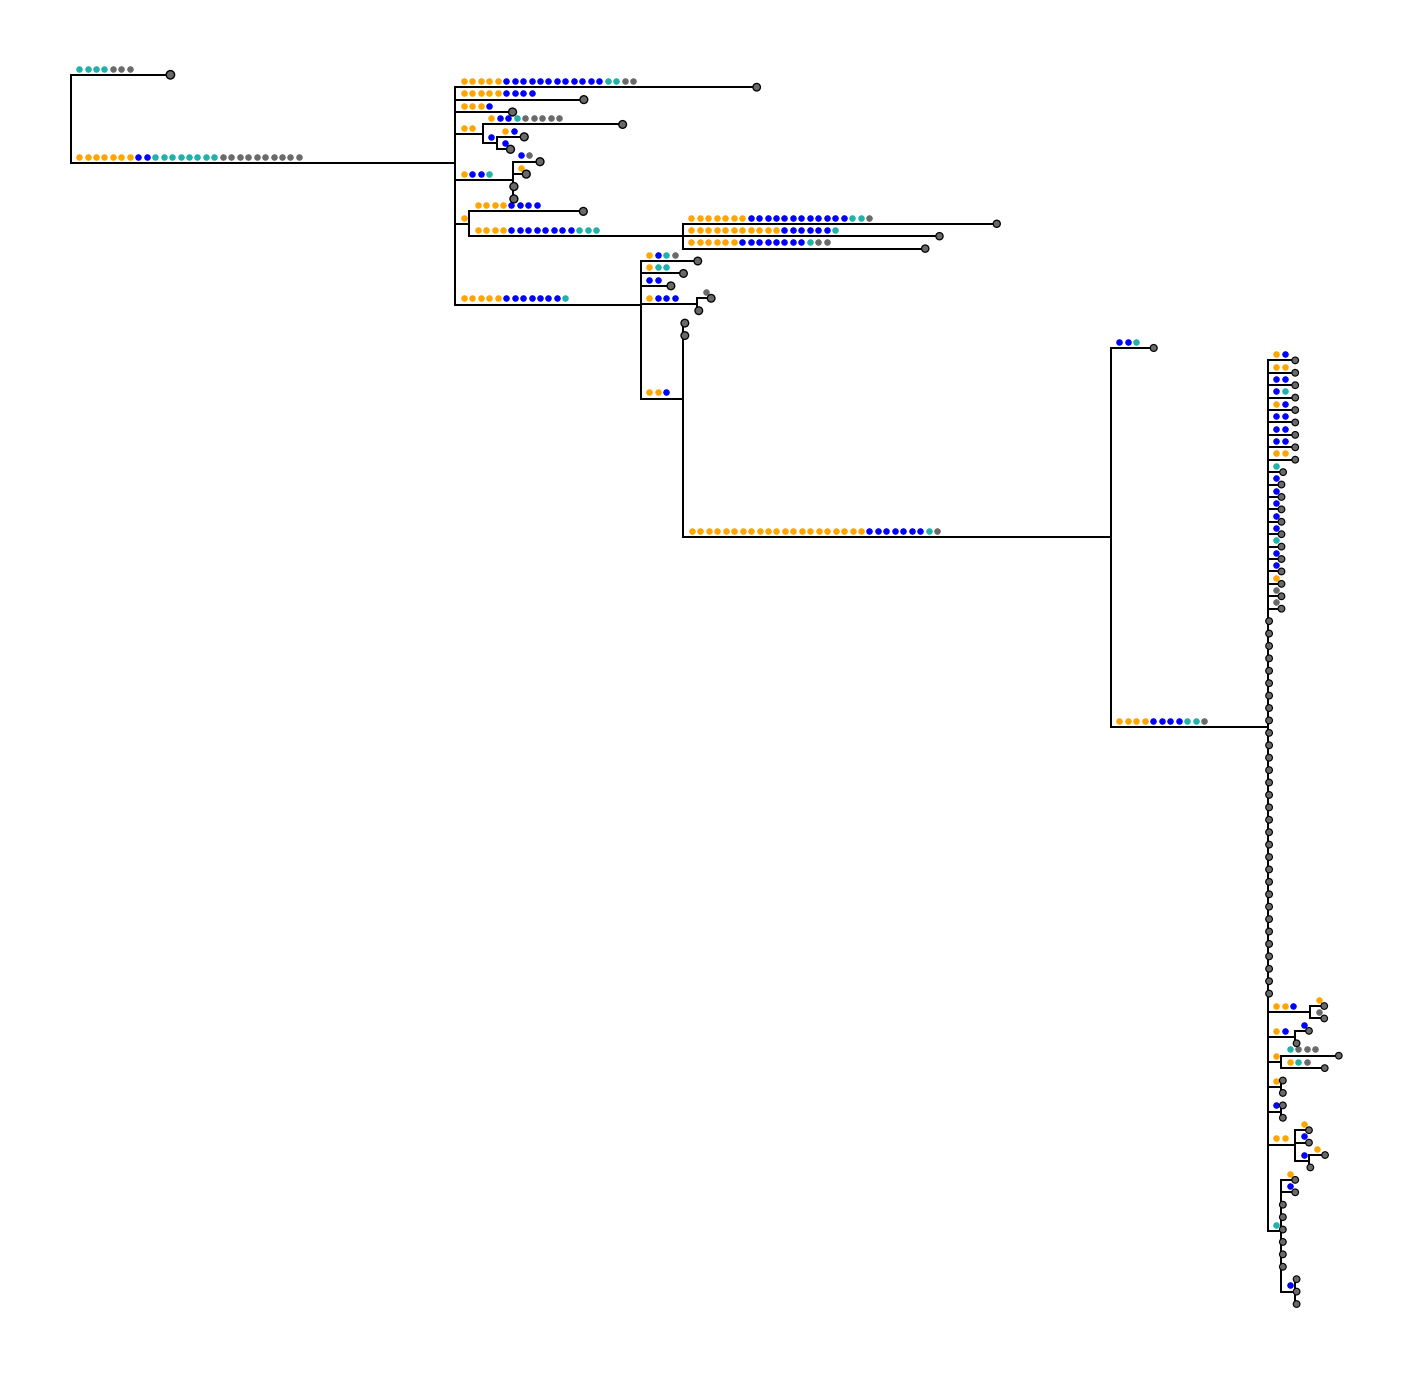

In [18]:
make_reconstruction_tree_figure("hMPXV_2022-06-09_101_genomes_cds",
                                "reconstruction_20220609/hMPXV_2022-06-09_101_genomes.fasta.pruned.tree.branch_snps.reconstruction.csv",
                                "reconstruction_20220609/hMPXV_2022-06-09_101_genomes.fasta.pruned.tree",)


## Get aa category functions <a class="anchor" id="synonymous"></a>


In [7]:
def get_aa_position(index,based=0):
    if based != 0:
        index -= based 

    remainder = index%3
    position_dict = {1:2,2:3,0:1}
    
    return position_dict[remainder]

def reverse_aa_position(start,end,site):
    index_dict = {}
    index = 0
    rev_position_dict = {1:2,2:3,0:1}
    for i in reversed(range(start,end)):
        remainder = index%3
        index_dict[i] = rev_position_dict[remainder]
        index +=1 

    position = index_dict[site]
    
    return position

def get_codon_indexes(aa_position,index):
    codon = []
    if aa_position == 1:
        codon = [index,index+1,index+2]
    elif aa_position == 2:
        codon = [index-1,index,index+1]
    elif aa_position == 3:
        codon =  [index-2,index-1,index]
    else:
        print("incorrect aa position")
        
    return codon

def get_codon_indexes_rev_strand(position,index):
    codon = []
    if position == 3:
        codon = [index,index+1,index+2]
    elif position == 2:
        codon = [index-1,index,index+1]
    elif position == 1:
        codon =  [index-2,index-1,index]
    return codon


def get_gene_boundaries():
    genes = {}
    gene_id = 0
    with open("/Users/s1680070/repositories/alignHPXV/squirrel/data/gene_boundaries.csv","r") as f:
        reader = csv.DictReader(f)
        for row in reader:
            gene_id +=1
            name = f"{row['Name'].replace(' ','_')}_{gene_id}"
            start = int(row["Minimum"]) - 1
            end = int(row["Maximum"])
            length = int(row["Length"])
            direction = row["Direction"]
            genes[(start,end)]=(name,length,direction)
    return genes

def get_grantham_scores():
    grantham_scores = {}

    with open("metadata/grantham_score.txt","r") as f:
        reader = csv.DictReader(f, delimiter="\t")
        for row in reader:
            for col in row:
                if col!="FIRST":
                    mutation = f"{row['FIRST']}{col}"

                    if row[col] != "0":
                        grantham_scores[mutation] = int(row[col])                    
                        grantham_scores[mutation[::-1]] = int(row[col])
    return grantham_scores
 
    
def categorise_amino_acid_mutation(aa1,aa2,grantham_scores):
    
    mutation_category = ""
    if aa1 == aa2:
        mutation_category = "synonymous"
    else:
        if aa2 == '*':
            mutation_category = "nonsense"
        else:
            mutation_category = "nonsynonymous"

    if f"{aa1}{aa2}" in grantham_scores:
        score = grantham_scores[f"{aa1}{aa2}"]
        if score < 51:
            prediction = "conservative"
        elif score <101:
            prediction = "moderately conservative"
        elif score <151:
            prediction = "moderately radical"
        else:
            prediction = "radical"
    else:
        score = "NA"
        prediction = "NA"
    
    return mutation_category,score,prediction

def reconstruct_amino_acid_mutations(branch_snps,node_states,outfile):
    branch_snps_dict = get_branch_snps_sites(branch_snps)
    genes = get_gene_boundaries()
    grantham_scores = get_grantham_scores()
    
    fw = open(outfile,"w")
    fw.write("site,gene,direction,snp,dimer,apobec,aa_position,parent,parent_codon,parent_aa,")
    fw.write("child,child_codon,child_aa,mutation_category,score,prediction\n")
    
    for site in branch_snps_dict:
        site_found = False
        for gene in genes:
            start,end=gene

            if site in range(start,end):
                
                site_found = True
                name,length,direction = genes[gene]
                parent,child,snp,dimer = branch_snps_dict[site]

                if direction == "forward":
                    aa_position = get_aa_position(site,gene[0])
                    codon_indexes = get_codon_indexes(aa_position,site)
                else:
                    aa_position = reverse_aa_position(start,end,site)
                    codon_indexes = get_codon_indexes_rev_strand(aa_position,site)
                    
                parent_codon = []
                child_codon = []

                for base in codon_indexes:
                    reconstruction = node_states[f"{base}"]
                    for node in reconstruction:
                        if node[0] == parent:
                            parent_codon.append(node[1])

                        elif node[0] == child:
                            child_codon.append(node[1])

                parent_codon = "".join(parent_codon)
                child_codon = "".join(child_codon)

                parent_codon = Seq(parent_codon)
                child_codon = Seq(child_codon)
                
                if direction == "reverse":
                    parent_codon= parent_codon.reverse_complement()
                    child_codon= child_codon.reverse_complement()
                    
                parent_aa = parent_codon.translate()
                child_aa = child_codon.translate()
                
                mutation_category,score,prediction = categorise_amino_acid_mutation(parent_aa,child_aa,grantham_scores)
                apobec = "False"
                if snp in ["C->T","G->A"] and dimer in ["GA","TC"]:
                    apobec = "True"
                    
                fw.write(f"{site},{name},{direction},{snp},{dimer},{apobec},{aa_position},{parent},{parent_codon},{parent_aa},{child},{child_codon},{child_aa},{mutation_category},{score},{prediction}\n")                                    
        
        if not site_found:
            parent,child,snp,dimer = branch_snps_dict[site]
            apobec = "False"
            if snp in ["C->T","G->A"] and dimer in ["GA","TC"]:
                apobec = "True"
            fw.write(f"{site},{name},NA,{snp},{dimer},{apobec},NA,{parent},NA,NA,{child},NA,NA,intergenic,NA,NA\n")                                    
            
    fw.close()
            

In [48]:
node_states = get_node_states_all_sites("reconstruction_20220609","hMPXV_2022-06-09_101_genomes.fasta.state","hMPXV_2022-06-09_101_genomes.aln.fasta")



In [191]:
reconstruct_amino_acid_mutations("reconstruction_20220609/hMPXV_2022-06-09_101_genomes.fasta.pruned.tree.branch_snps.reconstruction.csv",
                                node_states, "reconstruction_20220609/hMPXV_2022-06-09_101_genomes.amino_acid.reconstruction.csv")

    


## aa category figure functions <a class="anchor" id="aacategory"></a>


In [192]:
df = pd.read_csv("reconstruction_20220609/hMPXV_2022-06-09_101_genomes.amino_acid.reconstruction.csv")
df

,site,gene,direction,snp,dimer,apobec,aa_position,parent,parent_codon,parent_aa,child,child_codon,child_aa,mutation_category,score,prediction
0,13625,OPG025_CDS_169,reverse,G->A,GT,False,1.0,Node1,CGG,R,KJ642617|Nigeria-SE-1971|Nigeria||1971,TGG,W,nonsynonymous,101.0,moderately radical
1,98727,OPG118_CDS_82,forward,C->T,AC,False,1.0,Node1,CGA,R,KJ642617|Nigeria-SE-1971|Nigeria||1971,TGA,*,nonsense,NaN,NaN
2,119718,OPG137_CDS_63,forward,T->C,NaN,False,1.0,Node1,TCA,S,KJ642617|Nigeria-SE-1971|Nigeria||1971,CCA,P,nonsynonymous,74.0,moderately conservative
3,129762,OPG151_CDS_49,forward,A->G,NaN,False,3.0,Node1,TGA,*,KJ642617|Nigeria-SE-1971|Nigeria||1971,TGG,W,nonsynonymous,NaN,NaN
4,149744,OPG175_CDS_29,forward,G->A,GT,False,1.0,Node1,GTG,V,KJ642617|Nigeria-SE-1971|Nigeria||1971,ATG,M,nonsynonymous,21.0,conservative
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
296,133714,OPG108_CDS_92,NaN,C->T,TC,True,NaN,Node23,NaN,NaN,ON676708|USA_2021_MD|USA|2021-11,NaN,NaN,intergenic,NaN,NaN
297,51559,OPG071_CDS_129,reverse,G->A,GA,True,2.0,Node2,TCG,S,MT903339|MPXV-M3021_Delta|Nigeria_Delta_State|...,TTG,L,nonsynonymous,145.0,moderately radical
298,60923,OPG080_CDS_120,reverse,C->T,TC,True,3.0,Node2,ACG,T,MT903339|MPXV-M3021_Delta|Nigeria_Delta_State|...,ACA,T,synonymous,NaN,NaN
299,138584,OPG156_CDS_45,reverse,G->A,GA,True,3.0,Node2,ATC,I,MT903339|MPXV-M3021_Delta|Nigeria_Delta_State|...,ATT,I,synonymous,NaN,NaN


417


/Users/s1680070/opt/miniconda3/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/s1680070/opt/miniconda3/lib/python3.8/site-packages/seaborn/distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.1 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


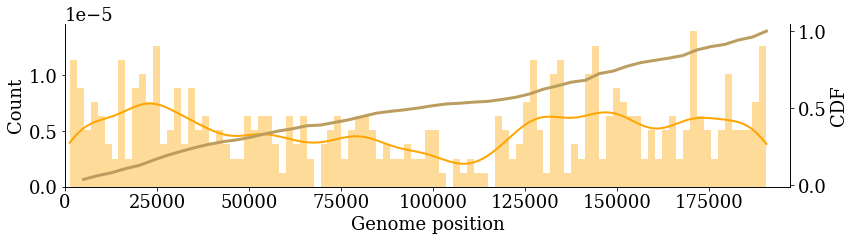

In [352]:
from scipy.stats import norm
sites = []
with open("updated_B1_2022-07-14/whole_dataset/hMPXV1_393.aln.fasta.pruned.tree.branch_snps.reconstruction.csv","r") as f:
    reader = csv.DictReader(f)
    for row in reader:
#         print(row)
        if row["dimer"] in ['GA',"TC"]:
            sites.append(int(row["site"]))
#             sites.append(int(row["site"]))
#             sites.append(int(row["site"]))
#             sites.append(int(row["site"]))
y = []
print(len(sites))
for site in sites:
    y.append(1)
    
fig,ax= plt.subplots(figsize=(13,3),facecolor='w',frameon=False)
sns.distplot(sites,  
             color="orange",
             bins=100,
             kde=True,
             kde_kws={"bw":0.1,"lw": 2, "label": "KDE","shade":False,"cut":0},
             rug=False, 
             hist=True
             )
# plt.plot(sites,norm.cdf(sites))
sites = sorted(sites)

count, bins_count = np.histogram(sites, bins=50)

pdf = count / sum(count)
cdf = np.cumsum(pdf)
ax2 = ax.twinx()
ax2.plot(bins_count[1:], cdf, label="CDF",lw=3)

# sns.kdeplot(sites, shade=True, bw=0.1, color="orange",alpha=0.2,cut=0)
# kde_kws={"bw":0.1,"lw": 2, "label": "KDE","shade":False,"cut":0}
[ax2.spines[loc].set_visible(False) for loc in ['top']]
[ax.spines[loc].set_visible(False) for loc in ['top']]

plt.xlim(0,197209)

ax.set_xlabel('Genome position')
ax.set_ylabel('Count')
ax2.set_ylabel('CDF')

plt.savefig("figures/apobec_distribution.393.double.svg");
plt.savefig("figures/apobec_distribution.393.double.png",bbox_inches='tight', 
               transparent=True);



414


/Users/s1680070/opt/miniconda3/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


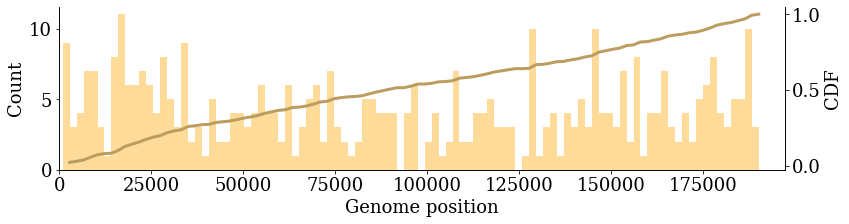

In [345]:
sites = []
with open("variola_reconstruction/variola_alignment.fasta.pruned.tree.branch_snps.reconstruction.csv","r") as f:
    reader = csv.DictReader(f)
    for row in reader:
#         print(row)
        if row["dimer"] in ['GA',"TC"]:
            sites.append(int(row["site"]))
#             sites.append(int(row["site"]))
y = []
print(len(sites))
for site in sites:
    y.append(1)
    
fig,ax= plt.subplots(figsize=(13,3),facecolor='w',frameon=False)
sns.distplot(sites,  
             color="orange",
             bins=100,
             kde=False,
             rug=False, 
             hist=True
             )
# plt.plot(sites,norm.cdf(sites))
sites = sorted(sites)

count, bins_count = np.histogram(sites, bins=100)

pdf = count / sum(count)
cdf = np.cumsum(pdf)
ax2 = ax.twinx()
ax2.plot(bins_count[1:], cdf, label="CDF",lw=3)

# sns.kdeplot(sites, shade=True, bw=0.1, color="orange",alpha=0.2,cut=0)
# kde_kws={"bw":0.1,"lw": 2, "label": "KDE","shade":False,"cut":0}
[ax2.spines[loc].set_visible(False) for loc in ['top']]
[ax.spines[loc].set_visible(False) for loc in ['top']]


ax.set_xlabel('Genome position')
ax.set_ylabel('Count')
ax2.set_ylabel('CDF')

plt.xlim(0,197209)

plt.xlabel("Genome position")
    
plt.savefig("figures/apobec_distribution.variola.double.svg");
plt.savefig("figures/apobec_distribution.variola.double.png",bbox_inches='tight', 
               transparent=True);


191635


/Users/s1680070/opt/miniconda3/lib/python3.8/site-packages/seaborn/distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.1 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
/Users/s1680070/opt/miniconda3/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/s1680070/opt/miniconda3/lib/python3.8/site-packages/seaborn/distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.1 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


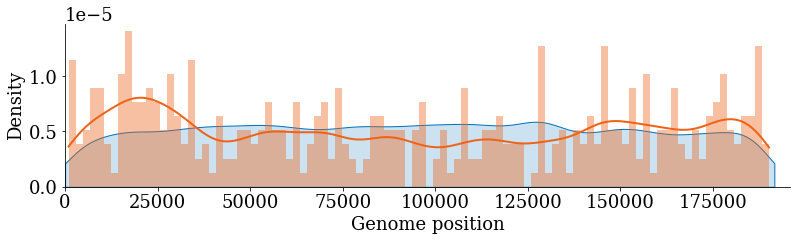

In [372]:
def make_dimer_density_plot(inseq,sites,outfile):
#     for record in SeqIO.parse(infile,"fasta"):
#         seq = str(record.seq)
    target_sites = []
    edited_sites = []
    for i in range(1,len(inseq)):
        base_1 = inseq[i-1]
        base_2 = inseq[i]

        dimer = f"{base_1}{base_2}"
        if dimer == "TC":
            target_sites.append(i)
        elif dimer == "GA":
            target_sites.append(i-1)
#         elif dimer == "TT":
#             edited_sites.append(i)
#         elif dimer == "AA":
#             edited_sites.append(i-1)
    print(sorted(target_sites)[-1])
    fig,ax= plt.subplots(figsize=(13,3),facecolor='w',frameon=False)
    sns.kdeplot(target_sites, shade=True, bw=0.1, color="#0071BC",alpha=0.2,cut=0)
#     sns.kdeplot(sites, shade=True, bw=0.1, color="#EF6318",alpha=0.2,cut=0)
    sns.distplot(sites,  
             color="#EF6318",
             bins=100,
             kde=True,
             kde_kws={"bw":0.1,"lw": 2, "label": "KDE","shade":False,"cut":0},
             rug=False, 
             hist=True
             )

    [ax.spines[loc].set_visible(False) for loc in ['top','right']]

    plt.xlim(0,196000)

    plt.xlabel("Genome position")

    plt.savefig(f"figures/{outfile}.svg");
    plt.savefig(f"figures/{outfile}.png",bbox_inches='tight', 
                   transparent=True);


    
sites = []
with open("variola_reconstruction/variola_alignment.fasta.pruned.tree.branch_snps.reconstruction.csv","r") as f:
    reader = csv.DictReader(f)
    for row in reader:
#         print(row)
        if row["dimer"] in ['GA',"TC"]:
            sites.append(int(row["site"]))
#             sites.append(int(row["site"]))
    
        
seq = ""
for record in SeqIO.parse("variola_reconstruction/variola_alignment.fasta","fasta"):
    if "DQ437586" in record.id:
        seq = str(record.seq)
make_dimer_density_plot(seq,sites,"apobec_SNP_target_distribution.VARV")



197209 197209


/Users/s1680070/opt/miniconda3/lib/python3.8/site-packages/seaborn/distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.1 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
/Users/s1680070/opt/miniconda3/lib/python3.8/site-packages/seaborn/distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.1 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


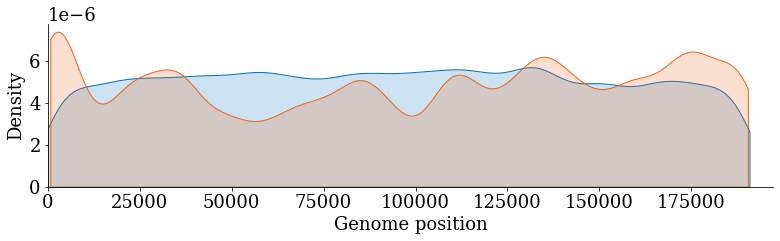

In [360]:
def make_dimer_density_plot_C1_C2(inseq1,inseq2,sites,outfile):
#     for record in SeqIO.parse(infile,"fasta"):
#         seq = str(record.seq)
    target_sites = []
    edited_sites = []
    for i in range(1,len(inseq1)):
        base_1 = inseq1[i-1]
        base_2 = inseq1[i]

        dimer = f"{base_1}{base_2}"
        if dimer == "TC":
            target_sites.append(i)
        elif dimer == "GA":
            target_sites.append(i-1)
#         elif dimer == "TT":
#             edited_sites.append(i)
#         elif dimer == "AA":
#             edited_sites.append(i-1)
    for i in range(1,len(inseq2)):
        base_1 = inseq2[i-1]
        base_2 = inseq2[i]

        dimer = f"{base_1}{base_2}"
        if dimer == "TC":
            target_sites.append(i)
        elif dimer == "GA":
            target_sites.append(i-1)
#         elif dimer == "TT":
#             edited_sites.append(i)
#         elif dimer == "AA":
#             edited_sites.append(i-1)

    fig,ax= plt.subplots(figsize=(13,3),facecolor='w',frameon=False)
    sns.kdeplot(target_sites, shade=True, bw=0.1, color="#0071BC",alpha=0.2,cut=0)
    sns.kdeplot(sites, shade=True, bw=0.1, color="#EF6318",alpha=0.2,cut=0)

    [ax.spines[loc].set_visible(False) for loc in ['top','right']]

    plt.xlim(0,197209)

    plt.xlabel("Genome position")

    plt.savefig(f"figures/{outfile}.svg");
    plt.savefig(f"figures/{outfile}.png",bbox_inches='tight', 
                   transparent=True);

    
seq1 = ""
for record in SeqIO.parse("reconstruction_clades1-3/clade1.aln.fasta","fasta"):
    if "DQ011154" in record.id:
        seq1 = str(record.seq)
seq2 = ""
for record in SeqIO.parse("reconstruction_clades1-3/clade2.aln.fasta","fasta"):
    if "KP849470" in record.id:
        seq2 = str(record.seq)
print(len(seq2), len(seq1))        



sites = []
with open("reconstruction_clades1-3/clade1.aln.fasta.pruned.tree.branch_snps.reconstruction.csv","r") as f:
    reader = csv.DictReader(f)
    for row in reader:
#         print(row)
        if row["dimer"] in ['GA',"TC"]:
            sites.append(int(row["site"]))
#             sites.append(int(row["site"]))

with open("reconstruction_clades1-3/clade2.aln.fasta.pruned.tree.branch_snps.reconstruction.csv","r") as f:
    reader = csv.DictReader(f)
    for row in reader:
#         print(row)
        if row["dimer"] in ['GA',"TC"]:
            sites.append(int(row["site"]))
            
            
make_dimer_density_plot_C1_C2(seq1,seq2,sites,"apobec_SNP_target_distribution.C1_C2")


71


/Users/s1680070/opt/miniconda3/lib/python3.8/site-packages/seaborn/distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.1 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


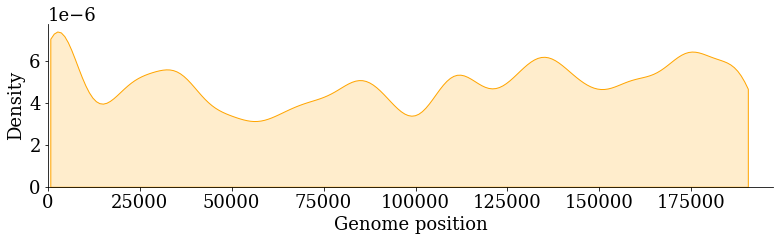

In [244]:
sites = []
with open("reconstruction_clades1-3/clade1.aln.fasta.pruned.tree.branch_snps.reconstruction.csv","r") as f:
    reader = csv.DictReader(f)
    for row in reader:
#         print(row)
        if row["dimer"] in ['GA',"TC"]:
            sites.append(int(row["site"]))
#             sites.append(int(row["site"]))

with open("reconstruction_clades1-3/clade2.aln.fasta.pruned.tree.branch_snps.reconstruction.csv","r") as f:
    reader = csv.DictReader(f)
    for row in reader:
#         print(row)
        if row["dimer"] in ['GA',"TC"]:
            sites.append(int(row["site"]))
#             sites.append(int(row["site"]))
y = []
print(len(sites))
for site in sites:
    y.append(1)
    
fig,ax= plt.subplots(figsize=(13,3),facecolor='w',frameon=False)
# sns.histplot(sites,  color="orange",alpha=0.2,bins=100,kde=True)

sns.kdeplot(sites, shade=True, bw=0.1, color="orange",alpha=0.2,cut=0)
[ax.spines[loc].set_visible(False) for loc in ['top','right']]

plt.xlim(0,197209)

plt.xlabel("Genome position")
    
plt.savefig("figures/apobec_distribution.C1_C2.svg");
plt.savefig("figures/apobec_distribution.C1_C2.png",bbox_inches='tight', 
               transparent=True);


190781


/Users/s1680070/opt/miniconda3/lib/python3.8/site-packages/seaborn/distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.1 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
/Users/s1680070/opt/miniconda3/lib/python3.8/site-packages/seaborn/distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.1 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


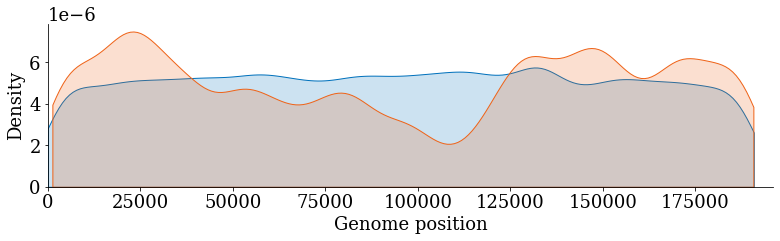

In [370]:
seq = ""
for record in SeqIO.parse("/Users/s1680070/repositories/alignHPXV/squirrel/data/NC_063383.aln.fasta","fasta"):
    seq = str(record.seq)

    
sites = []
with open("updated_B1_2022-07-14/whole_dataset/hMPXV1_393.aln.fasta.pruned.tree.branch_snps.reconstruction.csv","r") as f:
    reader = csv.DictReader(f)
    for row in reader:
#         print(row)
        if row["dimer"] in ['GA',"TC"]:
            sites.append(int(row["site"]))
            
make_dimer_density_plot(seq,sites,"apobec_SNP_target_distribution.MPXV")


parent,child,site,snp,dimer

Node1,Node2,3450,G->A,GA

Node1,Node2,8893,C->A,

Node1,Node2,18312,G->A,GA

Node1,Node2,19367,C->T,TC

Node1,Node2,33143,C->T,TC

Node1,Node2,38067,G->A,GC

Node1,Node2,46895,G->A,GT

Node1,Node2,48138,A->G,

Node1,Node2,48527,C->A,

Node1,Node2,53207,C->A,

Node1,Node2,66580,G->A,GA

Node1,Node2,80986,C->T,GC

Node1,Node2,92516,T->C,

Node1,Node2,100562,C->T,GC

Node1,Node2,105126,T->C,

Node1,Node2,128076,G->A,GA

Node1,Node2,133145,C->T,AC

Node1,Node2,137627,G->A,GT

Node1,Node2,141300,G->A,GA

Node1,Node2,141364,C->T,GC

Node1,Node2,142450,C->A,

Node1,Node2,146687,T->C,

Node1,Node2,149878,A->G,

Node1,Node2,160867,G->A,GT

Node1,Node2,167656,G->T,

Node1,Node2,171675,G->A,GA

Node1,Node2,178423,G->A,GA

Node2,Node7,23564,C->T,TC

Node2,Node7,72362,C->T,TC

Node2,Node7,83326,C->T,TC

Node2,Node7,87230,G->A,GA

Node2,Node7,87297,G->A,GA

Node2,Node7,91728,G->A,GA

Node2,Node7,119296,C->T,TC

Node2,Node7,121320,C->T,GC

Node2,Node7,125249,G->A,GA

Node

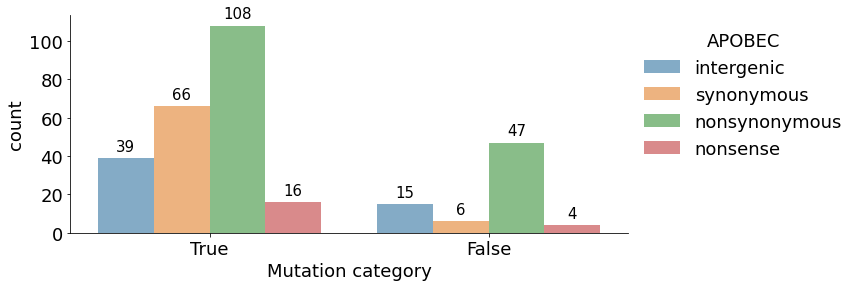

In [57]:
df = pd.read_csv("reconstruction_20220609/hMPXV_2022-06-09_101_genomes.amino_acid.reconstruction.csv")
fig,ax= plt.subplots(figsize=(10,4),facecolor='w',frameon=False)
ax = sns.countplot(x="apobec", hue="mutation_category", data=df, alpha=0.6, 
                   order=df['apobec'].value_counts().index,
                   hue_order=["intergenic","synonymous","nonsynonymous","nonsense"])
# bar_label = [1270,14707,5253,0,24,16]
bar_index = 0

for p in ax.patches:
    ax.annotate(p.get_height(), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   size=15,
                   xytext = (0, 12), 
                   textcoords = 'offset points')
    bar_index+=1
    
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1), frameon=False,title="APOBEC")
[ax.spines[loc].set_visible(False) for loc in ['top','right']]
plt.xlabel("Mutation category")
    
plt.savefig("figures/amino_acid_mutation_types.101_reconstruction.alt.svg");
plt.savefig("figures/amino_acid_mutation_types.101_reconstruction.alt.png",bbox_inches='tight', 
               transparent=True);

plt.show();

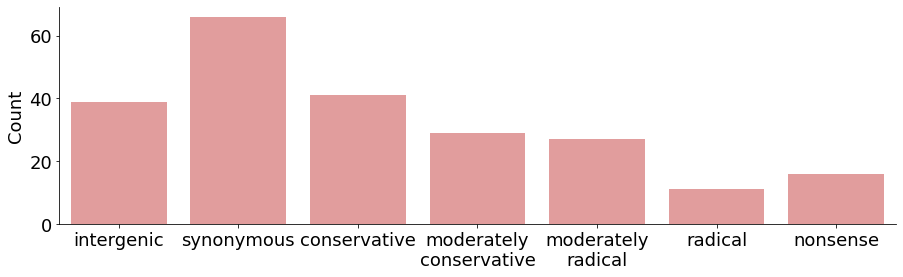

In [17]:
def amino_acid_categories_apobec_edited(infile,outfile):
    categories_edited = collections.Counter()
    with open(infile,"r") as f:
        reader = csv.DictReader(f)
        for row in reader:
            if row["apobec"] == "True":
                if row["mutation_category"] == "nonsynonymous":
                    categories_edited[row["prediction"]] +=1
                else:
                    categories_edited[row["mutation_category"]] +=1

    xe = ["intergenic","synonymous","conservative","moderately conservative","moderately radical","radical","nonsense"]
    ye = [categories_edited[i] for i in xe]
    fig,ax= plt.subplots(figsize=(15,4),facecolor='w',frameon=False)
    # df = df.sort_values('position').reset_index()
    bar1 = sns.barplot(x=xe, y=ye, alpha=0.6,facecolor="indianred")
    ax.set_xticklabels(["intergenic","synonymous","conservative","moderately\nconservative","moderately\nradical","radical","nonsense"])

    [ax.spines[loc].set_visible(False) for loc in ['top','right']]
    plt.xlabel("")
    plt.ylabel("Count")

    plt.savefig(f"figures/{outfile}.svg");
    plt.savefig(f"figures/{outfile}.png",bbox_inches='tight', 
                   transparent=True);

    plt.show();
    
amino_acid_categories_apobec_edited("reconstruction_20220609/hMPXV_2022-06-09_101_genomes.amino_acid.reconstruction.csv",
                                    "amino_acid_mutation_grantham_scores.101_reconstruction"
                                   )


In [14]:
def make_aa_reconstruction_tree_figure(outfile,aa_reconstruction,metadata,treefile):
    apobec_count = 0
    file = 0
    total = 0
    aa_info = collections.defaultdict(list)
    with open(aa_reconstruction,"r") as f:
        reader = csv.DictReader(f)
        for row in reader:
            if row["apobec"]=="True":
                file +=1
            aa_info[f'{row["parent"]}_{row["child"]}'].append((row["mutation_category"],row["apobec"],row["prediction"]))
    print(len(aa_info), file)
    my_tree=bt.loadNewick(treefile,absoluteTime=False)

    fig,ax = plt.subplots(figsize=(25,20),facecolor='w')
    
    x_attr=lambda k: k.height ## x coordinate of branches will be absoluteTime attribute
    su_func=lambda k: 50 ## size of tips
    s_func=lambda k: 30 ## size of tips
#     cd_func=lambda k: color_dict[k.traits["mutation_category"]]
    cu_func = lambda k: "black"
    c_func = lambda k: "dimgrey"
    
    for k in my_tree.Objects:
        if k.branchType == 'leaf':
            k.traits["label"]=k.name
    
    increment = my_tree.treeHeight/130
    
    my_tree.plotTree(ax,x_attr=x_attr,width=3) ## plot branches
#     my_tree.plotPoints(ax,size=su_func,colour=c_func,x_attr=x_attr,outline_colour=None) ## plot circles at tips
#     my_tree.plotPoints(ax,size=s_func,colour=c_func,x_attr=x_attr,outline_colour=None) ## plot circles at tips
    mpl.rcParams['font.family'] = 'sans-serif'

    for k in my_tree.Objects:
        current_node = k
        
        if k.branchType == 'leaf':
            current_node.traits["label"]=k.name
        
        node_name = current_node.traits["label"]
            
        try:
            parent_name = current_node.parent.traits["label"]
        except:
            continue
            
        branch_name= f"{parent_name}_{node_name}"

        if branch_name in aa_info:
            snps = []
#                 print(branch_name, len(branch_snps_dict[branch_name]))
            snp_placement = current_node.parent.height + increment*0.7
            non_syn_count = 0
            for s in aa_info[branch_name]:
                total+=1
                
                category,apobec,prediction = s
                if apobec=="False":
                    apobec_count+=1
                    if category == "synonymous":
                        snps.append((3,"#A8A8A8"))
                    elif category == "nonsynonymous":
                        non_syn_count+=1
                        snps.append((2,"#BD7988"))
                    elif category == "nonsense":
                        snps.append((1,"black"))
                    elif category == "intergenic":
                        snps.append((4,"#A8A8A8"))
                    else:
                        print("wtf?")
            plt.text(snp_placement+increment,k.y+0.9,non_syn_count)
            for snp in sorted(snps, key = lambda x : x[0]):
                
                plt.scatter([snp_placement],[k.y+0.5],color=snp[1],s=35)
                snp_placement += increment

    print(apobec_count,total)
    [ax.spines[loc].set_visible(False) for loc in ['top','right','left','bottom']]
    ax.tick_params(axis='y',size=0)
    ax.tick_params(axis='x',size=0)

    ax.set_yticklabels([])
    ax.set_xticklabels([])
    
    plt.savefig(f"figures/{outfile}.svg");
    plt.savefig(f"figures/{outfile}.png",bbox_inches='tight', 
                   transparent=True);
    plt.show()
    


59 327
84 411


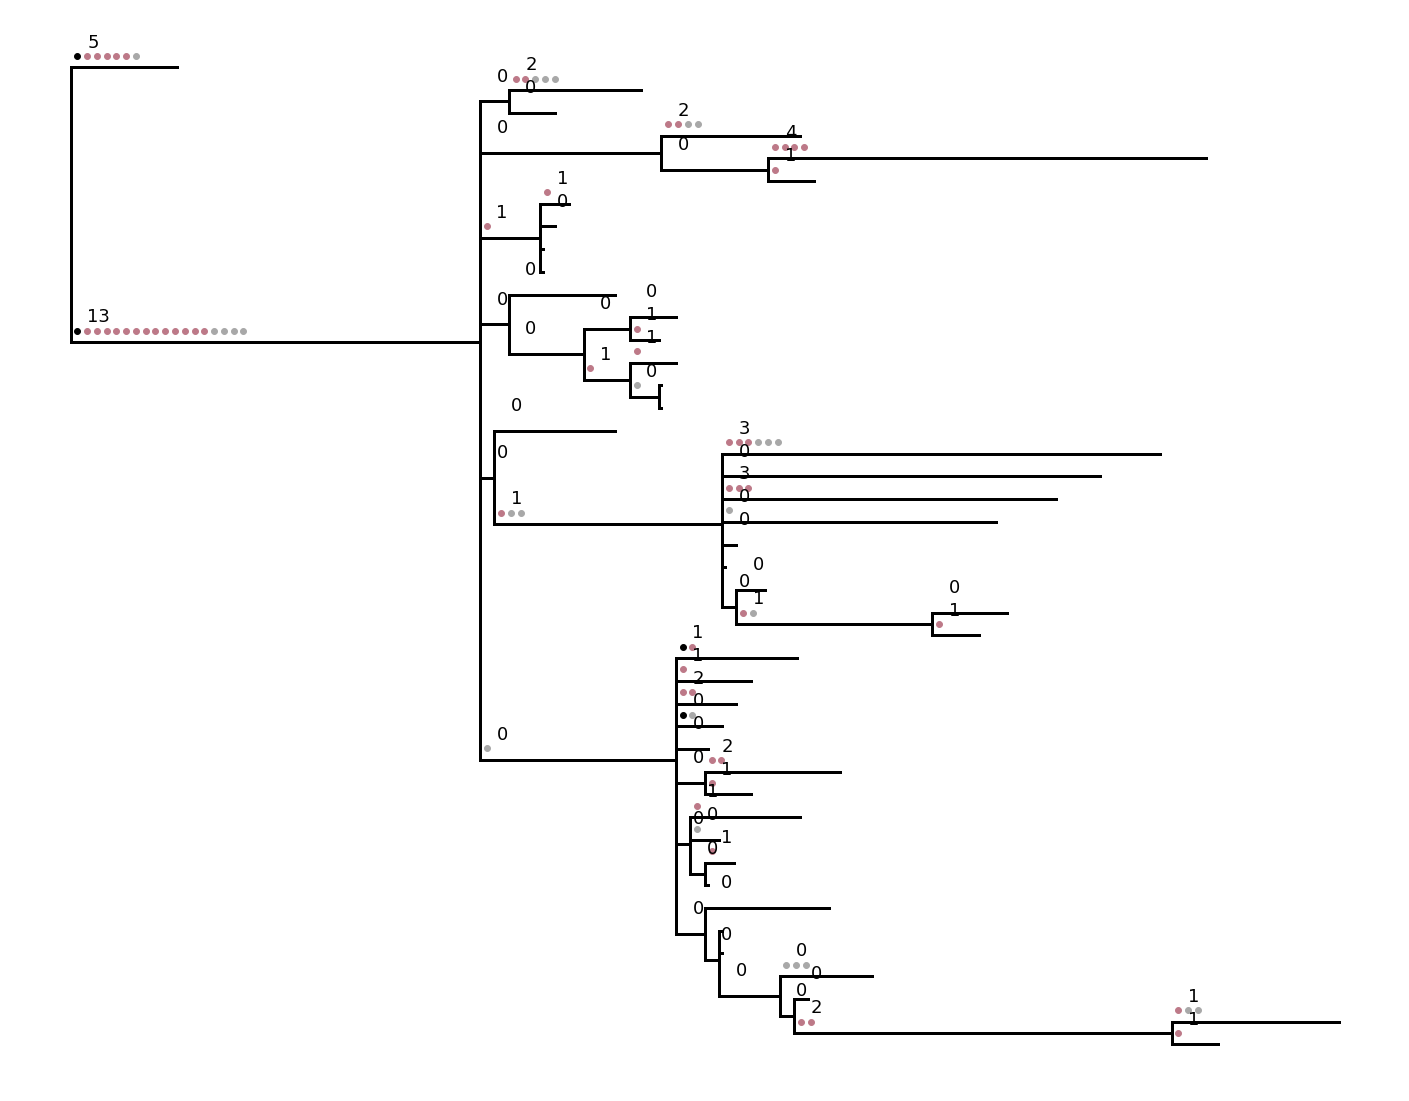

In [15]:

                                   
make_aa_reconstruction_tree_figure("amino_acid_category_apobec_tree.non_apobec",
                                   "updated_2022-09-02/hMPXV1/Clade_IIb_2022-08-22_with_gisaid.aln.pruned.tree.amino_acid.reconstruction.csv",
                                   "metadata/MPXV_metadata.csv",
                                    "updated_2022-09-02/hMPXV1/Clade_IIb_2022-08-22_with_gisaid.aln.pruned.tree")



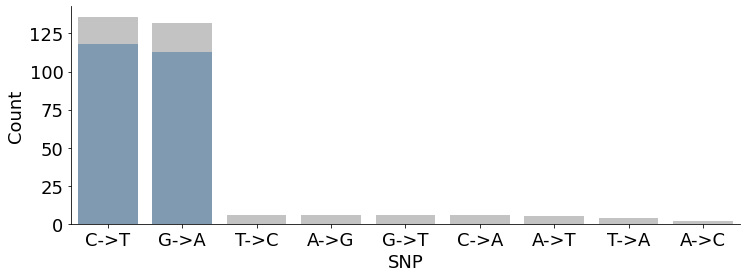

In [220]:
make_apobec_context_mutation_count_plot("reconstruction_20220609/hMPXV_2022-06-09_101_genomes.fasta.pruned.tree.branch_snps.reconstruction.csv",
                                        "reconstruction_20220609/hMPXV_2022-06-09_101_genomes.fasta.pruned.tree_genomes.fasta.pruned.tree.branch_snps.counts.csv",
                                        "hMPXV_2022-06-09_101_genomes_reconstruction.counts")

In [207]:
c =0
c2=0
with open("reconstruction_20220609/hMPXV_2022-06-09_101_genomes.2022_backbone_apobec.no_basal.csv","w") as fw:
    with open("reconstruction_20220609/hMPXV_2022-06-09_101_genomes.amino_acid.reconstruction.csv","r") as f:
        reader = csv.DictReader(f)

        writer = csv.DictWriter(fw,lineterminator="\n",delimiter=",", fieldnames=reader.fieldnames)
        writer.writeheader()
        for row in reader:
            branch= f'{row["parent"]}_{row["child"]}'
            if branch in ["Node2_Node16","Node16_Node21","Node21_Node23","Node23_Node24"]:
                c+=1
                if row["apobec"] == "True":
                    c2+=1
                    writer.writerow(row)
                else:
                    print(row.values())
print(c,c2)

# amino_acid_categories_apobec_edited("reconstruction_20220609/hMPXV_2022-06-09_101_genomes.2022_backbone_apobec.csv",
#                                     "amino_acid_mutation_grantham_scores.backbone_apobec"
#                                    )
"""
G->A GG
G->A GG
G->A GC

C->T GC

A->C 
"""



dict_values(['121320', 'OPG139_CDS_61', 'reverse', 'C->T', 'GC', 'False', '3', 'Node2', 'TCG', 'S', 'Node16', 'TCA', 'S', 'synonymous', 'NA', 'NA'])
dict_values(['14000', 'OPG025_CDS_169', 'reverse', 'G->T', '', 'False', '1', 'Node21', 'CCC', 'P', 'Node23', 'ACC', 'T', 'nonsynonymous', '38', 'conservative'])
dict_values(['95034', 'OPG115_CDS_85', 'forward', 'G->A', 'GC', 'False', '1', 'Node21', 'GCC', 'A', 'Node23', 'ACC', 'T', 'nonsynonymous', '58', 'moderately conservative'])
dict_values(['151461', 'OPG176_CDS_28', 'NA', 'A->C', '', 'False', 'NA', 'Node23', 'NA', 'NA', 'Node24', 'NA', 'NA', 'intergenic', 'NA', 'NA'])
dict_values(['155795', 'OPG176_CDS_28', 'NA', 'G->A', 'GG', 'False', 'NA', 'Node23', 'NA', 'NA', 'Node24', 'NA', 'NA', 'intergenic', 'NA', 'NA'])
dict_values(['170262', 'OPG198_CDS_14', 'forward', 'G->A', 'GG', 'False', '1', 'Node23', 'GGA', 'G', 'Node24', 'AGA', 'R', 'nonsynonymous', '125', 'moderately radical'])
57 51


## Clade 1 analysis <a class="anchor" id="clade1"></a>

In [231]:
generate_reconstruction_files("reconstruction_clades1-3",
                              "clade1.aln.fasta",
                              "clade1.aln.fasta.pruned.tree")

TypeError: generate_reconstruction_files() missing 1 required positional argument: 'node_states'

In [232]:
load_info("reconstruction_clades1-3",
          "clade1.aln.fasta",
          "clade1.aln.fasta.pruned.tree",
          "clade1_reconstruction_sq")

FileNotFoundError: [Errno 2] No such file or directory: 'reconstruction_clades1-3/clade1.aln.fasta.pruned.tree.state_differences.csv'

In [ ]:

make_aa_reconstruction_tree_figure("amino_acid_category_apobec_tree.101_reconstruction",
                                   "reconstruction_clades1-3/clade1.fasta.pruned.treefile.branch_snps.reconstruction.csv",
                                   "metadata/MPXV_metadata.csv",
                                    "reconstruction_clades1-3/clade1.fasta.pruned.treefile")

605 50 0.08264462809917356


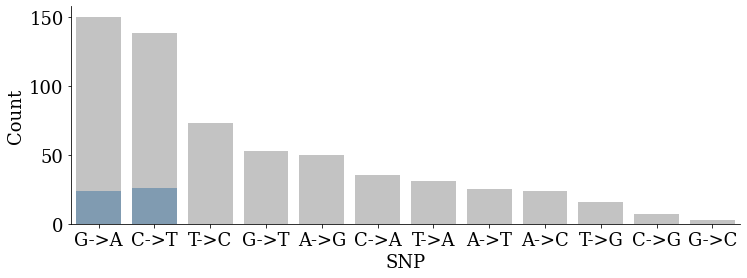

In [217]:
make_apobec_context_mutation_count_plot("reconstruction_clades1-3/clade1.fasta.pruned.treefile.branch_snps.reconstruction.csv",
                                        "reconstruction_clades1-3/clade1.fasta.pruned.treefile.branch_snps.counts.csv",
                                        "clade1_reconstruction.counts")

## Clade 2 analysis <a class="anchor" id="clade2"></a>

In [228]:
generate_reconstruction_files("reconstruction_clades1-3",
                              "clade2.fasta",
                              "clade2.fasta.pruned.treefile")

19 snps


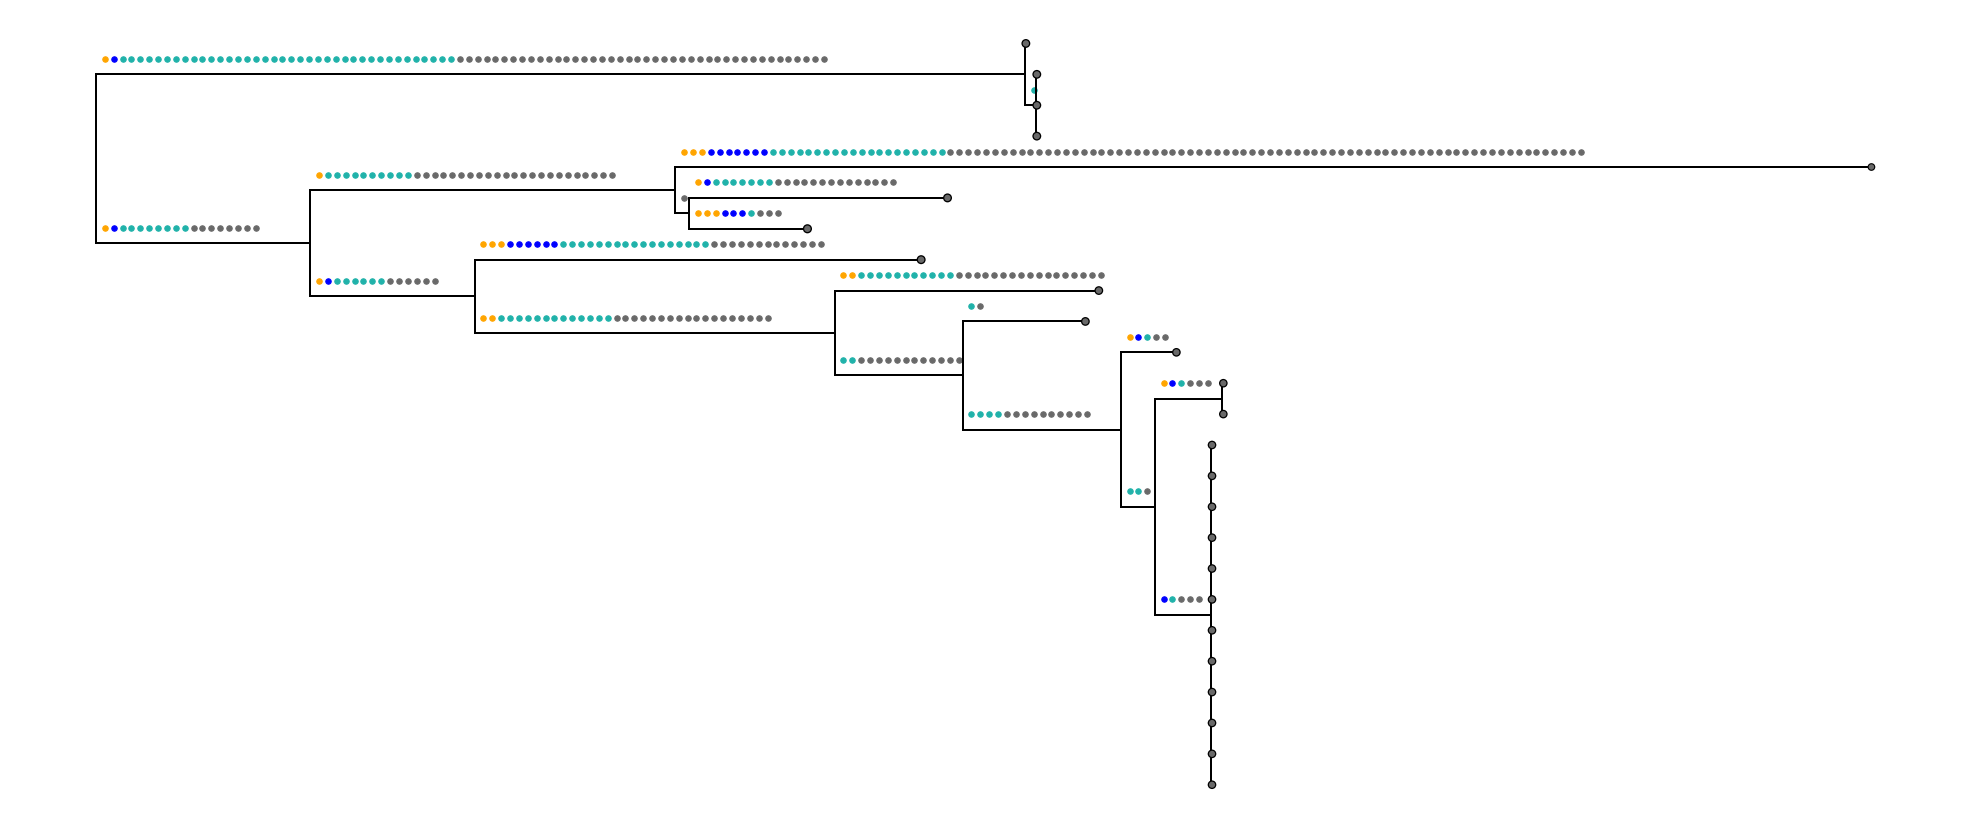

In [12]:
generate_reconstruction_files("reconstruction_clades1-3",
                              "clade2.fasta",
                              "clade2.fasta.pruned.treefile")
load_info("reconstruction_clades1-3",
          "clade2.fasta",
          "clade2.fasta.pruned.treefile",
          "clade2_reconstruction")

436 43 0.09862385321100918


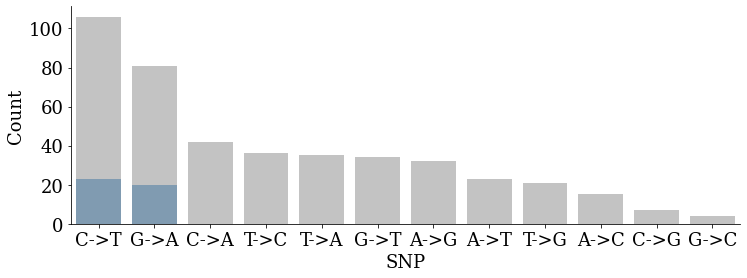

In [216]:
make_apobec_context_mutation_count_plot("reconstruction_clades1-3/clade2.fasta.pruned.treefile.branch_snps.reconstruction.csv",
                                        "reconstruction_clades1-3/clade2.fasta.pruned.treefile.branch_snps.counts.csv",
                                        "clade2_reconstruction.counts")

## Smallpox analysis  <a class="anchor" id="smallpox"></a>

In [216]:
generate_reconstruction_files("variola_reconstruction",
                              "variola_alignment.fasta",
                              "variola_alignment.fasta.pruned.tree")

71 snps


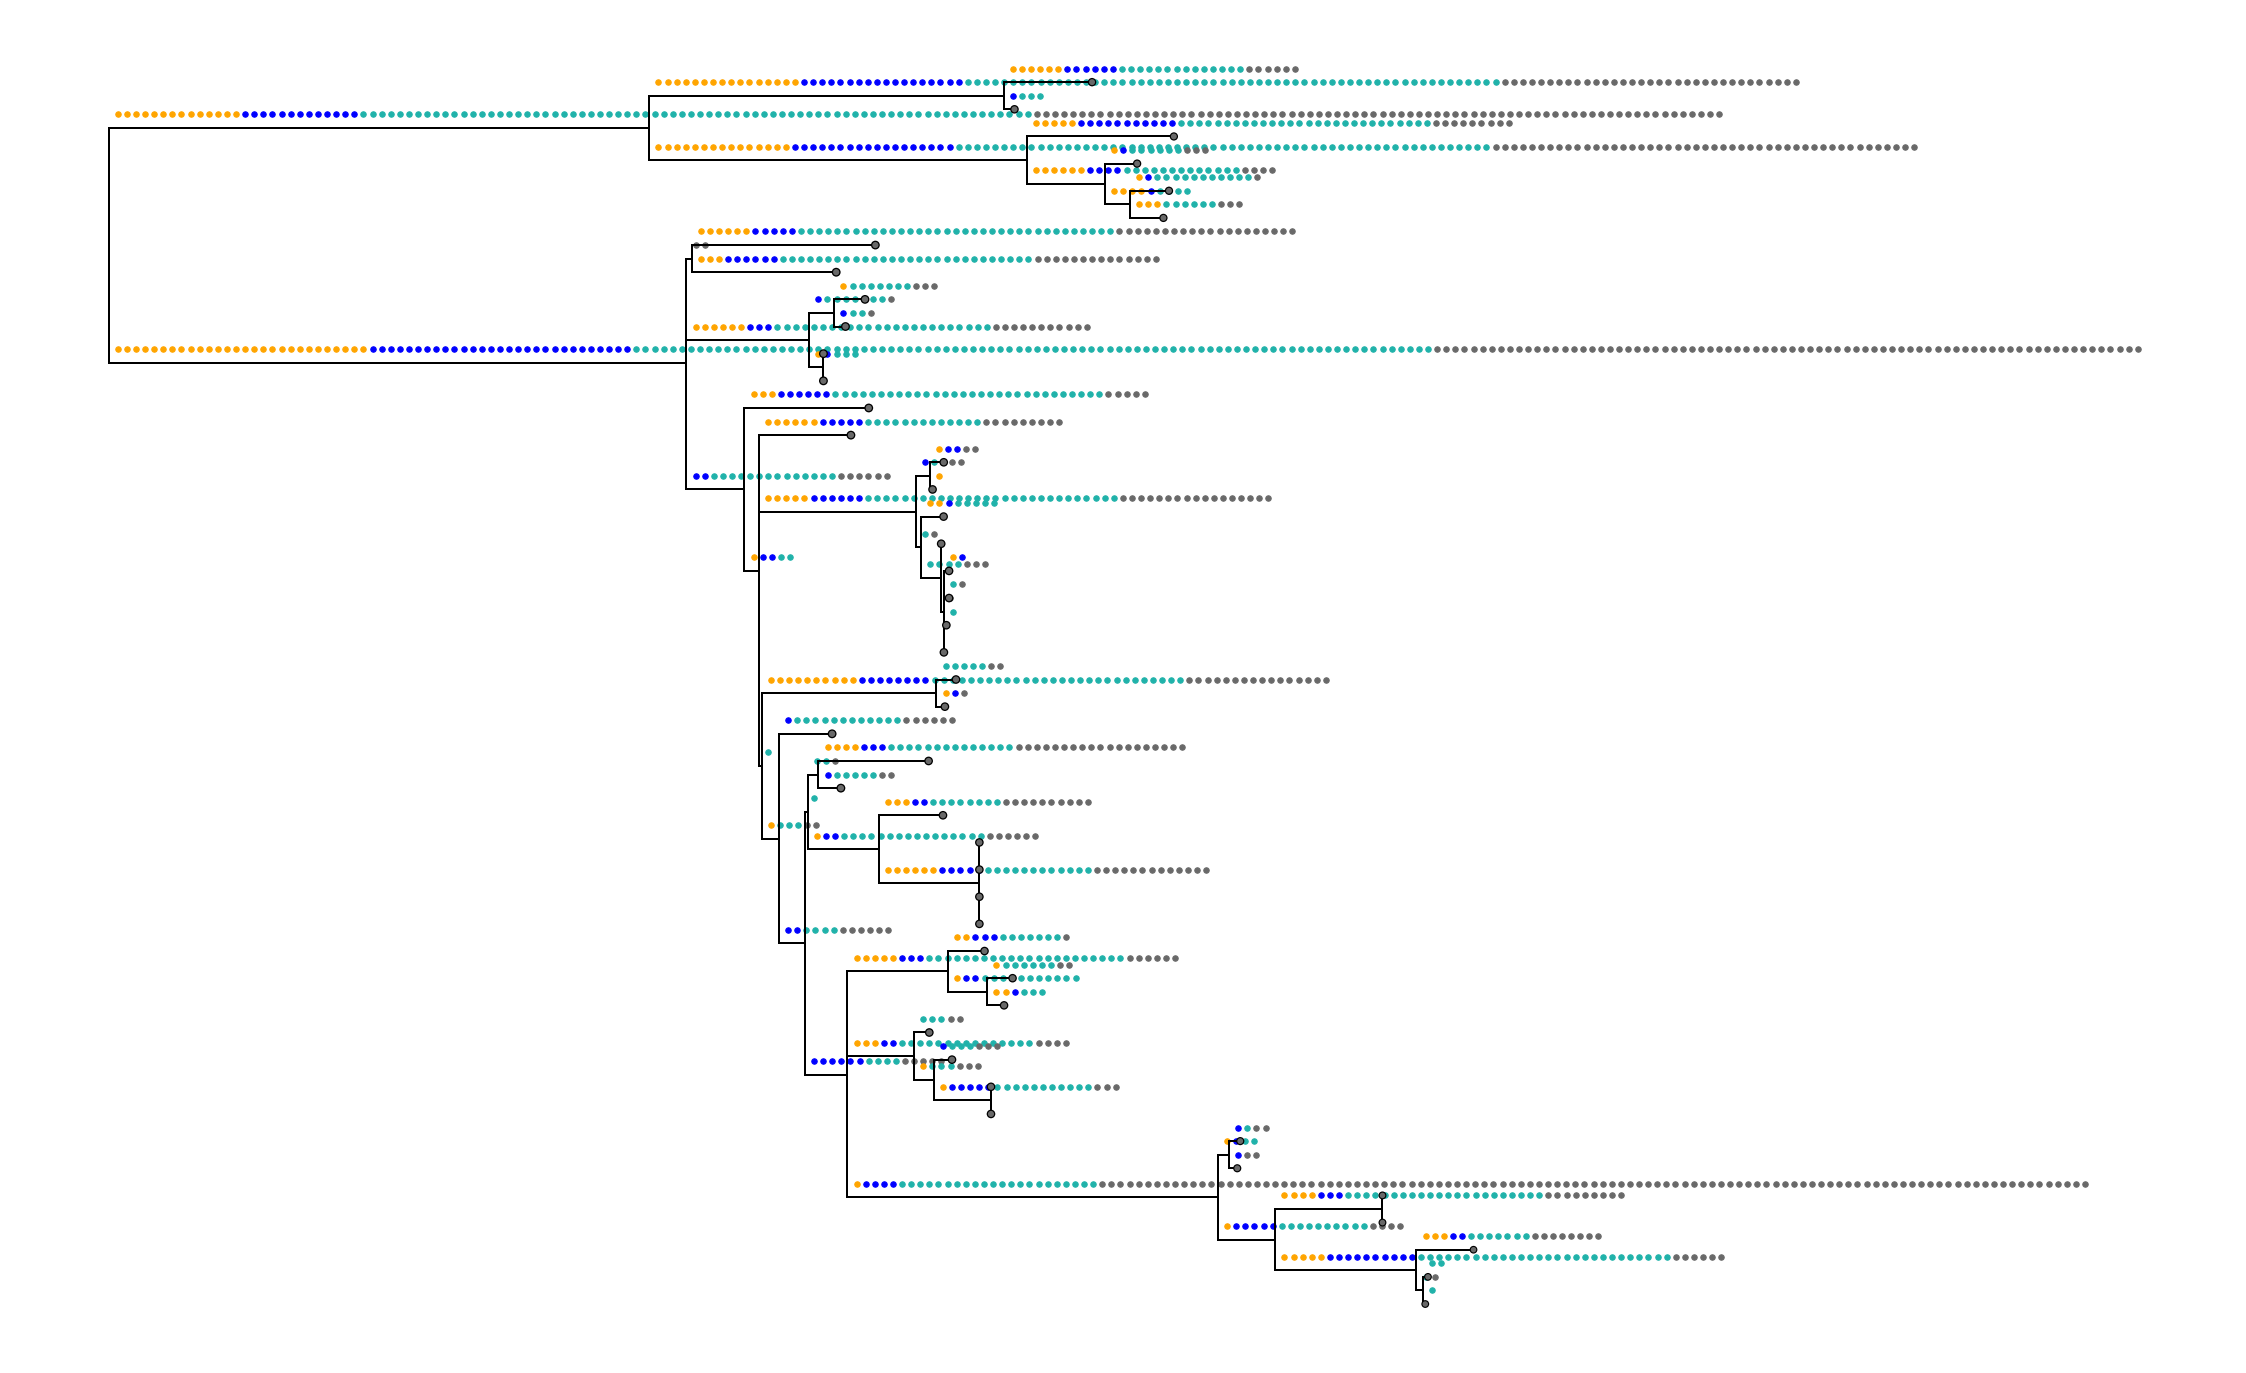

In [225]:
load_info("variola_reconstruction",
          "variola_alignment.fasta",
          "variola_alignment.fasta.pruned.tree",
          "variola_reconstruction.tree",80)

1894 414 0.21858500527983105


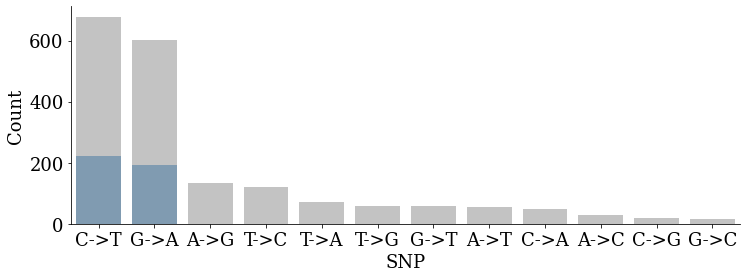

In [215]:
def make_apobec_context_mutation_count_plot(branch_snps,out_counts,outfigure):
    type_counter = collections.Counter()
    apobec_counter = collections.Counter()
    with open(branch_snps,"r") as f:
        all_snps_count = 0
        all_apobec_count = 0
        reader = csv.DictReader(f)
        for row in reader:
            if row["dimer"] in ["TC","GA"]:
                
                apobec_counter[f'{row["snp"]}']+=1
                all_apobec_count +=1
            
            type_counter[f'{row["snp"]}']+=1
            all_snps_count +=1
        
    print(all_snps_count, all_apobec_count, all_apobec_count/all_snps_count)  
    with open(out_counts,"w") as fw:
        fw.write("snp,count,target\n")            
        for i in sorted(type_counter, key=lambda x : type_counter[x], reverse=True):
            if i in apobec_counter:
                fw.write(f"{i},{type_counter[i]},{apobec_counter[i]}\n")
            else:
                fw.write(f"{i},{type_counter[i]},0\n")
    
    df = pd.read_csv(out_counts)
    fig,ax= plt.subplots(figsize=(12,4),facecolor='w',frameon=False)

    sns.barplot(x = 'snp', y = 'count', data = df, color = 'dimgrey',alpha=0.4)

    sns.barplot(x = 'snp', y = 'target', data = df, color = 'steelblue',alpha=0.6)

    [ax.spines[loc].set_visible(False) for loc in ['top','right']]
    plt.xlabel("SNP")
    plt.ylabel("Count")

    plt.savefig(f"figures/{outfigure}.svg");
    plt.savefig(f"figures/{outfigure}.png",bbox_inches='tight', 
                   transparent=True);

    plt.show();

    
make_apobec_context_mutation_count_plot("variola_reconstruction/variola_alignment.fasta.pruned.tree.branch_snps.reconstruction.csv",
                                        "variola_reconstruction/variola_alignment.fasta.pruned.tree.branch_snps.counts.csv",
                                        "variola_reconstruction.counts")



## CDS analysis: variola <a class="anchor" id="variolacds"></a>

In [277]:
def concatenate_coding_extraction(extraction):
    record_seq = ""
    for record in SeqIO.parse(extraction,"fasta"):
        seq = str(record.seq).replace("-","")
        if len(seq)%3==0 and seq.startswith("ATG"):
            record_seq += f"{seq}NNN"
        else:
            print(record.description, len(record.seq), len(seq))
    return record_seq

def get_at_content(seq):
    base_content = collections.Counter()
    for i in range(len(seq)):
        base_content[seq[i]]+=1
    informative_sites = 0
    at = 0
    for i in base_content:
        if i in ["A","T","C","G"]:
            informative_sites +=base_content[i]
        if i in ["A","T"]:
            at +=base_content[i]
    proportion = round(at/informative_sites, 100)
    return proportion

# record_seq = concatenate_coding_extraction("coding_region_smallpox/DQ437580.extraction.fasta")
# at_content = get_at_content(record_seq)

## All pox AT <a class="anchor" id="allpoxcds"></a>

In [280]:
from Bio import Entrez
Entrez.email = "aine.otoole@ed.ac.uk"

taxids= []
with open("non_monkeypox/all_pox.txt","r") as f:
    for l in f:
        l=l.rstrip()
        tokens = l.split(" ")
        for t in tokens:
            if t.startswith("NC_"):
                if t not in taxids:
                    taxids.append(t)
print(len(taxids))
# taxids = ",".join(taxids)

records = []
for query in taxids:
    handle = Entrez.efetch(db="nucleotide", id=query, rettype="gb", retmode="text")
    record = SeqIO.read(handle, "genbank")
    print(record.id)
    handle.close()
    records.append(record)


52
NC_055228.1
NC_055229.1
NC_055230.1
NC_055231.1
NC_037656.1
NC_036582.1
NC_035797.1
NC_035460.1
NC_035468.1
NC_035469.1
NC_035188.1
NC_032111.1
NC_031033.1
NC_031038.1
NC_030656.1
NC_028238.1
NC_027707.1
NC_027213.1
NC_024446.1
NC_024447.1
NC_023426.1
NC_022563.1
NC_021246.1
NC_021247.1
NC_021248.1
NC_021249.1
NC_016924.1
NC_015960.1
NC_013804.1
NC_008291.1
NC_008030.1
NC_006966.1
NC_005336.1
NC_005337.1
NC_005309.1
NC_005179.1
NC_004002.1
NC_004003.1
NC_003663.2
NC_003391.1
NC_003389.1
NC_003310.1
NC_003027.1
NC_002642.1
NC_002520.1
NC_002188.1
NC_001266.1
NC_001132.2
NC_004105.1
NC_001993.1
NC_001731.1
NC_001611.1


In [282]:
def get_host(record):
    host = ""
    if record.id in ["NC_001611.1","NC_001731.1","NC_035469.1","NC_055230.1"]:
        host = "Homo sapience"
    elif record.id in ["NC_004105.1","NC_003310.1","NC_008291.1",
                       "NC_022563.1","NC_027213.1","NC_031038.1",
                       "NC_031033.1","NC_032111.1","NC_035468.1","NC_035797.1"]:
        host = "Rodent"
    else:
        for f in record.features:
            if f.type=="source":
                try:
                    host = f.qualifiers["host"][0]
                except:
                    pass
    return host

def get_pubmed_id(record):
    pmid = ""
    authors = ""
    for ref in record.annotations["references"]:
        if ref.pubmed_id:
            pmid = ref.pubmed_id
        if ref.authors:
            authors = ref.authors
    return pmid, authors

    
get_pubmed_id(records[0])       


('28958947',
 "Bennett,M., O'Dea,M., Tu,S.-L., McArtor,C., Gillett,A., Laird,T. and Upton,C.")

In [283]:
record_seqs = {}

with open("non_monkeypox/52_reference_pox.gb","w") as fw:
    SeqIO.write(records,fw,"genbank")
with open("non_monkeypox/52_reference_pox.concatenated_cds.fasta","w") as fw2:
    with open("non_monkeypox/52_reference_pox.csv","w") as fw:
        fw.write("accession,organism,host,date,genome_length,AT_content,PMID,authors\n")
        for record in records:
            at_content = get_at_content(record.seq)
            host = get_host(record)

            pmid,authors = get_pubmed_id(record)
            fw.write(f'{record.id},{record.annotations["organism"]},{host},{record.annotations["date"]},{len(record.seq)},{at_content},{pmid},"{authors}"\n')
            record_seq = ""
            for feature in record.features:
                if feature.type=="CDS":
                    direction= feature.strand
                    cds_seq = feature.location.extract(record).seq

                    if len(cds_seq)%3 != 0:
                        print("not div of 3")

                    else:
                        record_seq+= f"{cds_seq}NNN"
            if len(record_seq) !=0:
                organism = record.annotations["organism"].replace(" ","_").replace("'","")
                fw2.write(f">{record.id}|{at_content}|{organism}|{host.replace(' ','_')}\n{record_seq}\n")
                

In [284]:
for record in SeqIO.parse("variola_reconstruction/ena_PRJEB38129_sequence.fasta","fasta"):
    
    at_content = get_at_content(record.seq)
    print(record.id, at_content)
    

ENA|LR800244|LR800244.1 0.6678115441230204
ENA|LR800245|LR800245.1 0.6679482243749154
ENA|LR800246|LR800246.1 0.6692414478552793
ENA|LR800247|LR800247.1 0.6689440166271416


steelblue
indianred


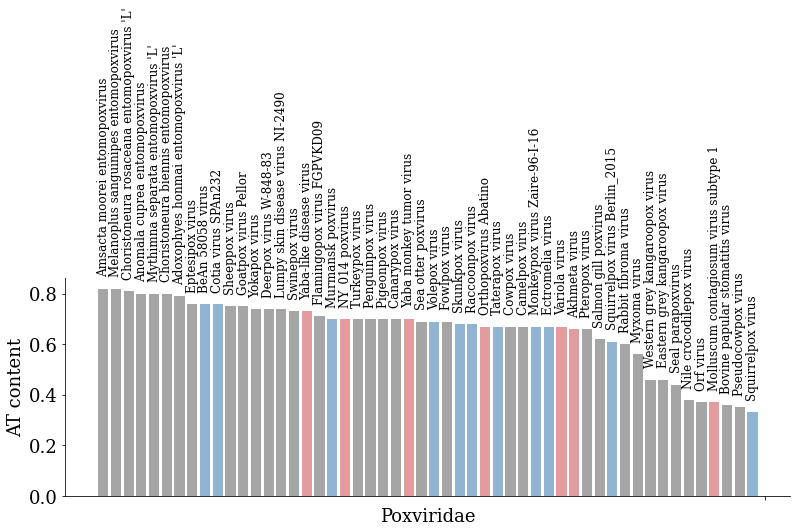

In [285]:
x = []
y = []
labels = []
colours = []

col_dict = {
    "NC_001611.1":"indianred",
    "NC_001731.1":"indianred",
    "NC_055230.1":"indianred",
    "NC_035469.1":"indianred",
    "NC_003310.1":"steelblue",
    "NC_031038.1":"steelblue",
    "NC_031033.1":"steelblue",
    "NC_022563.1":"steelblue"
#     "NC_003663.2":"lightseagreen"
}
lab_dict = {
    "NC_001611.1":"VARV",
    "NC_001731.1":"MOCV",
    "NC_055230.1":"Akhmeta virus",
    "NC_035469.1":"NY_014",
    "NC_003310.1":"MPXV",
    "NC_031033.1":"Volepox",
    "NC_031038.1":"Skunkpox",
    "NC_022563.1":"Squirrel pox",
    "NC_003663.2":"Cowpox"
}

bars = {}
with open("non_monkeypox/52_reference_pox.grouped_host.csv","r") as f:
    reader = csv.DictReader(f)
    for row in reader:
        if row["host"] == "Homo sapiens":
            col_dict[row["accession"]] = "indianred"
        elif row["host"] in ["Macaca","Monkey"]:
            col_dict[row["accession"]] = "indianred"
        elif row["host"] == "Rodent":
            col_dict[row["accession"]] = "steelblue"
#         elif row["host"] == "Ungulate":
#             col_dict[row["accession"]] = "seagreen"

        lab_dict[row["accession"]] = row["organism"]
        bars[row["accession"]] = float(row["AT_content"])

for bar in sorted(bars, key = lambda x : bars[x], reverse=True):
#     print(bar,bars[bar])
    if bar in col_dict:
        colours.append(col_dict[bar])
    else:
        colours.append("dimgrey")
    if bar in lab_dict:
        labels.append(lab_dict[bar])
    else:
        labels.append("")
        
    x.append(bar)
    y.append(bars[bar])
        

        
fig,ax= plt.subplots(figsize=(13,4),facecolor='w',frameon=False)
bars = ax.bar(x, y, color=colours, alpha=0.6)

bar_index = 0
for p in bars:
    label = labels[bar_index]
    ax.annotate(label, 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'bottom', 
                   size=12,
                   xytext = (0, 12), 
                   textcoords = 'offset points',rotation=90)
    bar_index+=1

for i in set(col_dict.values()):
    print(i)
# sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1), frameon=False,title="APOBEC")
[ax.spines[loc].set_visible(False) for loc in ['top','right']]
plt.xticks("")
plt.xlabel("Poxviridae")
plt.ylabel("AT content")
  
plt.savefig("figures/all_pox.AT_content.long.svg");
plt.savefig("figures/all_pox.AT_content.long.png",bbox_inches='tight', 
               transparent=True);

plt.show();

In [ ]:
def get_dimer_ratio_edited(seqid,seq,scores,outhandle):
    dimer_dict = collections.defaultdict(list)
    for i in range(1,len(seq)):
        base_1 = seq[i-1]
        base_2 = seq[i]
        
        dimer = f"{base_1}{base_2}"
        if dimer in ["TC","TT"]:
            aa_position = get_aa_position(i, 0)
            codon_index = get_codon_indexes(aa_position,i)
            codon = "".join([seq[i] for i in codon_index])
            aa1 = Seq(codon).translate()
            mutated_codon = codon.replace("TC","TT")
            aa2 = Seq(mutated_codon).translate()
            mutation_category,score,prediction = categorise_amino_acid_mutation(aa2,aa1,grantham_scores)
            syn_non_syn[("TC",mutation_category)]+=1
        elif dimer in ["GA","AA"]:
            
        

In [580]:
"""
number of TT that would have been synonymous change from TC
number of NT that would have been synonymous change from NC (where N is anything - including T)
number of AA that would have been synonymous change from GA
number of AN that would have been synonymous change from GN
plus the above but would have been non-synonymous (don't worry about the amino acid radical/conservative for now)
number of TC that would result synonymous change to TT
number of NC that would result synonymous change to NT

number of GA that would result synonymous change to AA
number of GN that would result synonymous change to AN
"""


def get_full_table(seqid,seq,grantham_scores):
    full_table_counter = collections.Counter()
    for i in range(1,len(seq)):
        base_1 = seq[i-1]
        base_2 = seq[i]
        
        dimer = f"{base_1}{base_2}"
        if dimer in ["TT","GT","AT","NT"]:
            aa_position = get_aa_position(i, 0)
            codon_index = get_codon_indexes(aa_position,i)
            
            codon = "".join([seq[i] for i in codon_index])
            aa1 = Seq(codon).translate()
            mutated_codon = list(codon)
            mutated_codon[aa_position-1] = "C"
            mutated_codon = "".join(mutated_codon)
            aa2 = Seq(mutated_codon).translate()
            mutation_category,score,prediction = categorise_amino_acid_mutation(aa2,aa1,grantham_scores)
#             print(dimer, aa_position, codon,mutated_codon,mutation_category)
        elif dimer in ["AG","AA","AC","AT"]:
            aa_position = get_aa_position(i-1, 0)
            codon_index = get_codon_indexes(aa_position,i-1)
            codon = "".join([seq[i] for i in codon_index])
            aa1 = Seq(codon).translate()
            
            mutated_codon = list(codon)
            mutated_codon[aa_position-1] = "G"
            mutated_codon = "".join(mutated_codon)
            
            aa2 = Seq(mutated_codon).translate()
            mutation_category,score,prediction = categorise_amino_acid_mutation(aa2,aa1,grantham_scores)
#             print(dimer, aa_position, codon,mutated_codon,mutation_category)
        elif dimer in ["TC","CC","AC","GC"]:
            aa_position = get_aa_position(i, 0)
            codon_index = get_codon_indexes(aa_position,i)
            
            codon = "".join([seq[i] for i in codon_index])
            aa1 = Seq(codon).translate()
            mutated_codon = list(codon)
            mutated_codon[aa_position-1] = "T"
            mutated_codon = "".join(mutated_codon)
            aa2 = Seq(mutated_codon).translate()
            mutation_category,score,prediction = categorise_amino_acid_mutation(aa2,aa1,grantham_scores)
#             print(dimer, aa_position, codon,mutated_codon,mutation_category)
        elif dimer in ["GA","GC","GT","GG"]:
            aa_position = get_aa_position(i-1, 0)
            codon_index = get_codon_indexes(aa_position,i-1)
            codon = "".join([seq[i] for i in codon_index])
            aa1 = Seq(codon).translate()
            
            mutated_codon = list(codon)
            mutated_codon[aa_position-1] = "A"
            mutated_codon = "".join(mutated_codon)
            
            aa2 = Seq(mutated_codon).translate()
            mutation_category,score,prediction = categorise_amino_acid_mutation(aa2,aa1,grantham_scores)
#             print(dimer, aa_position, codon,mutated_codon,mutation_category)
        
        else:
            continue
            
        if dimer == "TT":
            full_table_counter[("TT",mutation_category)]+=1
        elif dimer == "AA":
            full_table_counter[("AA",mutation_category)]+=1
        elif dimer == "GA":
            full_table_counter[("GA",mutation_category)]+=1
        elif dimer == "TC":
            full_table_counter[("TC",mutation_category)]+=1

        if dimer in ["TT","GT","AT","NT"]:
            full_table_counter[("NT",mutation_category)]+=1
        elif dimer in ["AG","AA","AC","AT"]:
            full_table_counter[("AN",mutation_category)]+=1

        elif dimer in ["TC","CC","AC","GC"]:
            full_table_counter[("NC",mutation_category)]+=1

        elif dimer in ["GA","GC","GT","GG"]:
            full_table_counter[("GN",mutation_category)]+=1
    print(full_table_counter)
    return full_table_counter
            
        
with open("non_monkeypox/full_set_edited_non_edited_dimer_counts.csv","w") as fw:
    fw.write("virus,dimer,mutation_category,count\n")
            
    for record in SeqIO.parse("non_monkeypox/52_reference_pox.concatenated_cds.fasta","fasta"):

        if record.id in ["NC_001611.1|0.67|Variola_virus|Homo_sapiens",
                         "NC_003310.1|0.67|Monkeypox_virus_Zaire-96-I-16|Rodent"]:
            if record.id == "NC_001611.1|0.67|Variola_virus|Homo_sapiens":
                name = "VARV"

            elif record.id == "NC_003310.1|0.67|Monkeypox_virus_Zaire-96-I-16|Rodent":
                name = "MPXV"

        
            full_table_counter = get_full_table(name,str(record.seq),grantham_scores)
            for counter in full_table_counter:
                dimer,category = counter
                count = full_table_counter[counter]
                fw.write(f"{name},{dimer},{category},{count}\n")


Counter({('AN', 'nonsynonymous'): 27822, ('NT', 'nonsynonymous'): 24858, ('NT', 'synonymous'): 20021, ('AA', 'nonsynonymous'): 14636, ('GN', 'nonsynonymous'): 14396, ('AN', 'synonymous'): 11783, ('NC', 'nonsynonymous'): 11291, ('GA', 'nonsynonymous'): 10636, ('TT', 'nonsynonymous'): 8309, ('TT', 'synonymous'): 6642, ('NC', 'synonymous'): 6060, ('TC', 'nonsynonymous'): 5966, ('AA', 'synonymous'): 5150, ('GN', 'synonymous'): 4041, ('TC', 'synonymous'): 3323, ('GA', 'synonymous'): 2121, ('NT', 'nonsense'): 159, ('TT', 'nonsense'): 54, ('AN', 'nonsense'): 24})
Counter({('AN', 'nonsynonymous'): 26746, ('NT', 'nonsynonymous'): 23699, ('NT', 'synonymous'): 19142, ('AA', 'nonsynonymous'): 14249, ('GN', 'nonsynonymous'): 13293, ('AN', 'synonymous'): 11360, ('NC', 'nonsynonymous'): 10675, ('GA', 'nonsynonymous'): 9818, ('TT', 'nonsynonymous'): 8078, ('TT', 'synonymous'): 6517, ('TC', 'nonsynonymous'): 5611, ('NC', 'synonymous'): 5528, ('AA', 'synonymous'): 5093, ('GN', 'synonymous'): 3774, ('TC'

In [561]:
grantham_scores = get_grantham_scores()

def get_dimers_codons_mutations(seqid,seq,grantham_scores,outhandle,outhandle2):
    dimer_counter = collections.Counter()
    syn_non_syn = collections.Counter()
    for i in range(1,len(seq)):
        base_1 = seq[i-1]
        base_2 = seq[i]
        
        dimer = f"{base_1}{base_2}"
        dimer_counter[dimer]+=1
        mutated = False
        if dimer == "TC":
            aa_position = get_aa_position(i, 0)
            codon_index = get_codon_indexes(aa_position,i)
            codon = "".join([seq[i] for i in codon_index])
            aa1 = Seq(codon).translate()
#             if dimer == "TC":
                
#                 mutated_codon = codon.replace("TC","TT")
#                 aa2 = Seq(mutated_codon).translate()
#                 mutation_category,score,prediction = categorise_amino_acid_mutation(aa1,aa2,grantham_scores)
                
#             if dimer == "TT":
            mutated = True
            mutated_codon = codon.replace("TC","TT")
            aa2 = Seq(mutated_codon).translate()
            mutation_category,score,prediction = categorise_amino_acid_mutation(aa2,aa1,grantham_scores)
            syn_non_syn[("TC",mutation_category)]+=1
        elif dimer == "GA":
            aa_position = get_aa_position(i-1, 0)
            codon_index = get_codon_indexes(aa_position,i-1)
            codon = "".join([seq[i] for i in codon_index])
            aa1 = Seq(codon).translate()
#             if dimer == "GA":
#                 mutated_codon = codon.replace("GA","AA")
#                 aa2 = Seq(mutated_codon).translate()
#                 mutation_category,score,prediction = categorise_amino_acid_mutation(aa1,aa2,grantham_scores)
#             elif dimer == "AA":
            mutated = True
            mutated_codon = codon.replace("GA","AA")
            aa2 = Seq(mutated_codon).translate()
            mutation_category,score,prediction = categorise_amino_acid_mutation(aa2,aa1,grantham_scores)
            syn_non_syn[("GA",mutation_category)]+=1
        else:
            continue
            
        outhandle.write(f"{seqid},{dimer},{aa_position},{codon},{aa1},{aa2},{mutation_category},{score},{prediction},{mutated}\n")
#         print(f"{seqid},{dimer},{aa_position},{codon},{aa1},{aa2},{mutation_category},{score},{prediction},{mutated}")
    
    normalise_factor = collections.Counter()
    print(dimer_counter)
    for i in dimer_counter:
        if i in ["TC","TA","TG","TT"]:
            normalise_factor["TC"]+= dimer_counter[i]
        elif i in ["AA","CA","GA","TA"]:
            normalise_factor["GA"]+= dimer_counter[i]
    
    normalised_syn = collections.defaultdict(list)
    
    for i in syn_non_syn:
        count = syn_non_syn[i]
        normalised_syn[i[1]].append(round(count/normalise_factor[i[0]], 4))
        
        print(f"{seqid},{i[0]},{i[1]},{count},{normalise_factor[i[0]]},{round(count/normalise_factor[i[0]], 2)}")
    for i in normalised_syn:
        mean = (normalised_syn[i][0]+normalised_syn[i][1])/2
        outhandle2.write(f"{seqid},{i},{mean}\n")
    return normalise_factor
    

    
test1 = "ATCTCTCAA" 
test = "TGAGAGAAT" 
with open("non_monkeypox/all_pox.test.txt","w") as fw:
    fw.write("virus,dimer,aa_position,codon,aa1,aa2,mutation_category,score,prediction,edited\n")
    get_dimer_position_mutations("test",test1,grantham_scores,fw)

    get_dimer_position_mutations("test1",test,grantham_scores,fw)

# def get_apobec_edited_not_edited_sites():
    

In [562]:
with open("non_monkeypox/all_pox.dimers_apobec_mutations.csv","w") as fw:
    fw.write("virus,dimer,aa_position,codon,aa1,aa2,mutation_category,score,prediction,edited\n")
    fw2 = open("non_monkeypox/varv_mpxv.non_syn_syn.csv","w")
    fw2.write("virus,mutation_category,normalised_proportion\n")
    for record in SeqIO.parse("non_monkeypox/52_reference_pox.concatenated_cds.fasta","fasta"):
        if record.id in ["NC_001611.1|0.67|Variola_virus|Homo_sapiens",
#                         "NC_001731.1|0.37|Molluscum_contagiosum_virus_subtype_1|Homo_sapiens",
                         "NC_003310.1|0.67|Monkeypox_virus_Zaire-96-I-16|Rodent"]:
            if record.id == "NC_001611.1|0.67|Variola_virus|Homo_sapiens":
                name = "VARV"
    
            elif record.id == "NC_003310.1|0.67|Monkeypox_virus_Zaire-96-I-16|Rodent":
                name = "MPXV"
            normalisation_factor = get_dimers_codons_mutations(name,str(record.seq),grantham_scores,fw,fw2)
            print(name, normalisation_factor)
    fw2.close()

Counter({'AT': 21116, 'AA': 19786, 'TA': 18629, 'TT': 15005, 'GA': 12757, 'TG': 10343, 'AG': 10167, 'AC': 9676, 'CA': 9549, 'TC': 9289, 'GT': 8917, 'CT': 8228, 'GG': 5680, 'CG': 5084, 'CC': 4166, 'GC': 3896, 'NN': 382, 'NA': 190, 'AN': 167, 'GN': 24})
MPXV,GA,synonymous,2563,42092,0.06
MPXV,TC,synonymous,6047,53266,0.11
MPXV,TC,nonsynonymous,3242,53266,0.06
MPXV,GA,nonsynonymous,10194,42092,0.24
MPXV Counter({'TC': 53266, 'GA': 42092})
Counter({'AT': 19903, 'AA': 19342, 'TA': 17931, 'TT': 14655, 'GA': 11757, 'TG': 9635, 'AG': 9627, 'AC': 9165, 'CA': 8979, 'TC': 8523, 'GT': 8442, 'CT': 7744, 'GG': 5310, 'CG': 4703, 'CC': 3942, 'GC': 3738, 'NN': 394, 'NA': 196, 'AN': 169, 'GN': 28})
VARV,TC,nonsynonymous,3078,50744,0.06
VARV,TC,synonymous,5445,50744,0.11
VARV,GA,nonsynonymous,9405,40078,0.23
VARV,GA,synonymous,2352,40078,0.06
VARV Counter({'TC': 50744, 'GA': 40078})


In [526]:
# synonymous vs non-synonymous for edited/not-edited
# norm by total sites

edited_counter = collections.defaultdict(dict)
with open("non_monkeypox/all_pox.dimers_apobec_mutations.csv","r") as f:
    reader = csv.DictReader(f)
    for row in reader:
        if row["dimer"] in ["AA","GA"]:
            try:
                edited_counter[row["virus"]]["AA_GA"].append((row["dimer"],row["mutation_category"]))
            except:
                edited_counter[row["virus"]]["AA_GA"] = []
                edited_counter[row["virus"]]["AA_GA"].append((row["dimer"],row["mutation_category"]))
        else:
            try:
                edited_counter[row["virus"]]["TT_TC"].append((row["dimer"],row["mutation_category"]))

            except:
                edited_counter[row["virus"]]["TT_TC"] = []
                edited_counter[row["virus"]]["TT_TC"].append((row["dimer"],row["mutation_category"]))
                
normalised_counts = collections.Counter()
                
for i in edited_counter:
    for j in edited_counter[i]:
        print(i, len(edited_counter[i][j]))
        dimer_counts = collections.Counter()
        for site in edited_counter[i][j]:
            dimer_counts[site]+=1
        print(dimer_counts)
        norm_counts = {}
        for site in dimer_counts:
            norm_counts[site] = round(dimer_counts[site]/len(edited_counter[i][j]),2)
        print(norm_counts)
        print(sum(norm_counts.values()))
        print("\n")
        for site in norm_counts:
            if site[0] in ["TT","AA"]:
                normalised_counts[(i,"TT | AA",site[1])]+=norm_counts[site]
            else:
                normalised_counts[(i,"TC | GA",site[1])]+=norm_counts[site]
with open("non_monkeypox/normalised_mpxv_varv_edited_not_edited.csv","w") as fw:
    fw.write("virus,edited,mutation_category,normalised_proportion\n")
    for i in normalised_counts:
#         print(i, normalised_counts[i]/2)

    
    fw.write(f"{i[0]},{i[1]},{i[2]},{round(normalised_counts[i]/2,2)}\n")
        

MPXV 47863
Counter({('AA', 'nonsynonymous'): 20923, ('GA', 'nonsynonymous'): 17417, ('GA', 'synonymous'): 5176, ('AA', 'synonymous'): 4347})
{('GA', 'synonymous'): 0.11, ('AA', 'nonsynonymous'): 0.44, ('GA', 'nonsynonymous'): 0.36, ('AA', 'synonymous'): 0.09}
1.0


MPXV 39057
Counter({('TC', 'synonymous'): 13164, ('TT', 'nonsynonymous'): 12200, ('TT', 'synonymous'): 8371, ('TC', 'nonsynonymous'): 5322})
{('TT', 'synonymous'): 0.21, ('TC', 'synonymous'): 0.34, ('TC', 'nonsynonymous'): 0.14, ('TT', 'nonsynonymous'): 0.31}
1.0


VARV 23178
Counter({('TT', 'nonsynonymous'): 8312, ('TT', 'synonymous'): 6343, ('TC', 'synonymous'): 5445, ('TC', 'nonsynonymous'): 3078})
{('TC', 'nonsynonymous'): 0.13, ('TT', 'synonymous'): 0.27, ('TT', 'nonsynonymous'): 0.36, ('TC', 'synonymous'): 0.23}
0.99


VARV 31099
Counter({('AA', 'nonsynonymous'): 15660, ('GA', 'nonsynonymous'): 9405, ('AA', 'synonymous'): 3682, ('GA', 'synonymous'): 2352})
{('AA', 'nonsynonymous'): 0.5, ('GA', 'nonsynonymous'): 0.3, ('

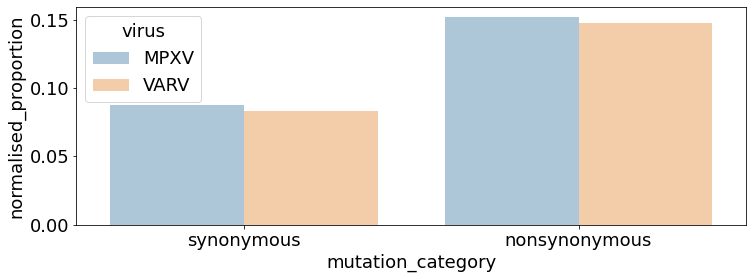

In [563]:

    
df = pd.read_csv("non_monkeypox/varv_mpxv.non_syn_syn.csv")
df
# fig,ax= plt.subplots(figsize=(12,4),facecolor='w',frameon=False)

# sns.barplot(df, "mutation_category", "normalised_proportion",hue="virus",order=["synonymous","nonsynonymous"], alpha=0.6,palette=("steelblue","indianred"))

fig,ax= plt.subplots(figsize=(12,4),facecolor='w',frameon=False)

sns.barplot(x = 'mutation_category', y = 'normalised_proportion', data = df,hue="virus",alpha=0.4)
#  order=['synonymous',
#                                                               'conservative',
#                                                               'moderately conservative',
#                                                               'moderately radical',
#                                                               'radical'
#                                                               ]
# # # [ax.spines[loc].set_visible(False) for loc in ['top','right']]
# plt.xlabel("")
# g.ylabel("Proportion normalised")
# title_dict = {"not_edited":"GA | CT","edited": "AA | TT"}
# axes = g.axes.flatten()
# axes[0].set_title("GA | CT")
# axes[1].set_title("AA | TT")

for ax in g.axes.flat:
    
    for label in ax.get_xticklabels():
        label.set_rotation(90)
plt.savefig(f"figures/pox_apobec_dimers.variola_vs_monkey.syn_non_syn.svg");
plt.savefig(f"figures/pox_apobec_dimers.variola_vs_monkey.syn_non_syn.png",bbox_inches='tight', 
               transparent=True);
g.add_legend()
plt.show();



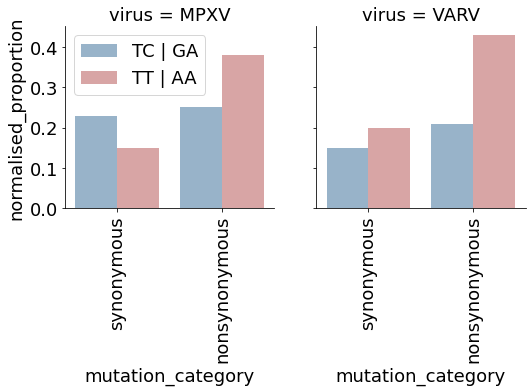

In [528]:

    
df = pd.read_csv("non_monkeypox/normalised_mpxv_varv_edited_not_edited.csv")
df
# fig,ax= plt.subplots(figsize=(12,4),facecolor='w',frameon=False)

g = sns.FacetGrid(df, col="virus", height=4, aspect=1,legend_out=False)
g.map(sns.barplot, "mutation_category", "normalised_proportion", hue=df["edited"],order=["synonymous","nonsynonymous"], alpha=0.6,palette=("steelblue","indianred"));


#  order=['synonymous',
#                                                               'conservative',
#                                                               'moderately conservative',
#                                                               'moderately radical',
#                                                               'radical'
#                                                               ]
# # # [ax.spines[loc].set_visible(False) for loc in ['top','right']]
# plt.xlabel("")
# g.ylabel("Proportion normalised")
# title_dict = {"not_edited":"GA | CT","edited": "AA | TT"}
# axes = g.axes.flatten()
# axes[0].set_title("GA | CT")
# axes[1].set_title("AA | TT")

for ax in g.axes.flat:
    
    for label in ax.get_xticklabels():
        label.set_rotation(90)
plt.savefig(f"figures/pox_apobec_dimers.variola_vs_monkey.mut_cat.svg");
plt.savefig(f"figures/pox_apobec_dimers.variola_vs_monkey.mut_cat.png",bbox_inches='tight', 
               transparent=True);
g.add_legend()
plt.show();



In [ ]:
# synonymous vs non-synonymous for edited/not-edited
# norm by total sites

edited_counter = collections.defaultdict(dict)
with open("non_monkeypox/all_pox.dimers_apobec_mutations.csv","r") as f:
    reader = csv.DictReader(f)
    for row in reader:
        if row["dimer"] in ["AA","GA"]:
            try:
                edited_counter[row["virus"]]["AA_GA"].append((row["dimer"],row["mutation_category"]))
            except:
                edited_counter[row["virus"]]["AA_GA"] = []
                edited_counter[row["virus"]]["AA_GA"].append((row["dimer"],row["mutation_category"]))
        else:
            try:
                edited_counter[row["virus"]]["TT_TC"].append((row["dimer"],row["mutation_category"]))

            except:
                edited_counter[row["virus"]]["TT_TC"] = []
                edited_counter[row["virus"]]["TT_TC"].append((row["dimer"],row["mutation_category"]))
                
normalised_counts = collections.Counter()
                
for i in edited_counter:
    for j in edited_counter[i]:
        print(i, len(edited_counter[i][j]))
        dimer_counts = collections.Counter()
        for site in edited_counter[i][j]:
            dimer_counts[site]+=1
        print(dimer_counts)
        norm_counts = {}
        for site in dimer_counts:
            norm_counts[site] = round(dimer_counts[site]/len(edited_counter[i][j]),2)
        print(norm_counts)
        print(sum(norm_counts.values()))
        print("\n")
        for site in norm_counts:
            if site[0] in ["TT","AA"]:
                normalised_counts[(i,"TT | AA",site[1])]+=norm_counts[site]
            else:
                normalised_counts[(i,"TC | GA",site[1])]+=norm_counts[site]
with open("non_monkeypox/normalised_mpxv_varv_nonsynonymous_categories.csv","w") as fw:
    fw.write("virus,edited,mutation_category,normalised_proportion\n")
    for i in normalised_counts:
#         print(i, normalised_counts[i]/2)
        fw.write(f"{i[0]},{i[1]},{i[2]},{round(normalised_counts[i]/2,2)}\n")
        

## Heptamer analysis <a class="anchor" id="heptamer"></a>

In [89]:
def get_heptamers(node_states):
    site_dict = collections.defaultdict(list)
    snp_count = 0
    with open("reconstruction_20220609/hMPXV_2022-06-09_101_genomes.fasta.pruned.tree.branch_snps.reconstruction.csv","r") as f:
        reader = csv.DictReader(f)
        for row in reader:
            if [row["parent"],row["child"]] not in [["Node1","KJ642617|Nigeria-SE-1971|Nigeria||1971"]]:
                snp_count +=1
                if row["snp"] in ["G->A","C->T"]:
                
                    site_dict[row["site"]] = (row["parent"],row["snp"])
    print(snp_count)
    heptamers = []
    for site in site_dict:
        
        parent,dimer = site_dict[site]
#         print(site, parent, dimer)
        site = int(site)
        indexes = []
        bases = []
        for i in range(site-3,site+4):
            indexes.append(i)
            nodes = node_states[f"{i}"]
            base = ""
            for node in nodes:
                if node[0] == parent:
                    base = node[1]
            bases.append(base)
        seq = "".join(bases)
        
        seq = Seq(seq)
        
        if dimer == "G->A":
            
            seq = seq.reverse_complement()
        
        heptamers.append(seq)
    return heptamers
              
def get_heptamers_backbone(node_states):
    site_dict = collections.defaultdict(list)
    snp_count = 0
    with open("reconstruction_20220609/hMPXV_2022-06-09_101_genomes.fasta.pruned.tree.branch_snps.reconstruction.csv","r") as f:
        reader = csv.DictReader(f)
        for row in reader:
            
            
            if [row["parent"],row["child"]] in [["Node2","Node16"],
                                                ["Node16","Node21"],["Node21","Node23"],
                                                ["Node23","Node24"]]:
                snp_count+=1
                if row["snp"] in ["G->A","C->T"]:
                    site_dict[row["site"]] = (row["parent"],row["snp"])
    heptamers = []
    print(snp_count)
    for site in site_dict:
        
        parent,dimer = site_dict[site]
#         print(site, parent, dimer)
        site = int(site)
        indexes = []
        bases = []
        for i in range(site-3,site+4):
            indexes.append(i)
            nodes = node_states[f"{i}"]
            base = ""
            for node in nodes:
                if node[0] == parent:
                    base = node[1]
            bases.append(base)
        seq = "".join(bases)
        
        seq = Seq(seq)
        
        if dimer == "G->A":
            
            seq = seq.reverse_complement()
        
        heptamers.append(seq)
    return heptamers
# heptamers = get_heptamers(node_states)



# print(len(node_states))


In [91]:
def make_heptamer_figure_101(heptamers):
    hept_dict = {}
    for i in range(7):
        hept_dict[i] = collections.Counter()

    rel_dict = {0:-3,1:-2,2:-1,3:0,4:1,5:2,6:3}
    mutations = 0

    with open("reconstruction_20220609/heptamer_composition.csv","w") as fw:
        fw.write("position,rel_position,base\n")
        for heptamer in heptamers:
            hept_list = list(heptamer)

            for i in range(len(hept_list)):
                hept_dict[i][hept_list[i]] +=1 
                fw.write(f"{i+1},{rel_dict[i]},{hept_list[i]}\n")
                
#             for i in hept_dict:
#                 print(i, hept_dict[i])
                        
    df = pd.read_csv("reconstruction_20220609/heptamer_composition.csv")
    df
    fig,ax= plt.subplots(figsize=(11,4),facecolor='w',frameon=False)
    colors = {"A":"#4682B4",
              "C":"indianred",
              "G":"#BC9D60",
              "T":"#87CEEB"}
    
    colors = ["#BC9D60","#87CEEB","#4682B4","indianred"]
    customPalette = sns.set_palette(sns.color_palette(colors))

#     legend_elements = [Line2D([0], [0], markerfacecolor='#4682B4',color='white',markersize=15,alpha=0.6, marker='o',label='A'),
#                        Line2D([0], [0], markerfacecolor='indianred',color='white',markersize=15,alpha=0.6, marker='o',label='C'),
#                        Line2D([0], [0], markerfacecolor='#BC9D60',color='white',markersize=15, alpha=0.6,marker='o',label='G'),
#                         Line2D([0], [0], markerfacecolor='#87CEEB',color='white',markersize=15,alpha=0.6, marker='o',label='T')]

    g = sns.histplot(data=df, x="rel_position",hue="base",multiple="fill",hue_order = ['A','C','G','T'],palette=customPalette,alpha=0.6,bins=7,linewidth=1)

    sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1), frameon=False,title="")
    plt.xlim(-3,3)

    plt.xlabel("Position\n");
    plt.ylabel("Proportion")
    [ax.spines[loc].set_visible(False) for loc in ['top','right']]

    plt.savefig(f"figures/heptamer_proportions.101.svg");
    plt.savefig(f"figures/heptamer_proportions.101.png",bbox_inches='tight', 
                   transparent=True);
    plt.show();
    
    
def make_heptamer_backbone_figure(heptamers):
    hept_dict = {}
    for i in range(7):
        hept_dict[i] = collections.Counter()

    rel_dict = {0:-3,1:-2,2:-1,3:0,4:1,5:2,6:3}
    mutations = 0

    with open("reconstruction_20220609/heptamer_backbone_composition.csv","w") as fw:
        fw.write("position,rel_position,base\n")
        for heptamer in heptamers:
            hept_list = list(heptamer)

            for i in range(len(hept_list)):
                hept_dict[i][hept_list[i]] +=1 
                fw.write(f"{i+1},{rel_dict[i]},{hept_list[i]}\n")
                
#             for i in hept_dict:
#                 print(i, hept_dict[i])
                        
    df = pd.read_csv("reconstruction_20220609/heptamer_backbone_composition.csv")
    df
    fig,ax= plt.subplots(figsize=(11,4),facecolor='w',frameon=False)
    colors = {"A":"#4682B4",
              "C":"indianred",
              "G":"#BC9D60",
              "T":"#87CEEB"}
    
    colors = ["#BC9D60","#87CEEB","#4682B4","indianred"]
    customPalette = sns.set_palette(sns.color_palette(colors))

#     legend_elements = [Line2D([0], [0], markerfacecolor='#4682B4',color='white',markersize=15,alpha=0.6, marker='o',label='A'),
#                        Line2D([0], [0], markerfacecolor='indianred',color='white',markersize=15,alpha=0.6, marker='o',label='C'),
#                        Line2D([0], [0], markerfacecolor='#BC9D60',color='white',markersize=15, alpha=0.6,marker='o',label='G'),
#                         Line2D([0], [0], markerfacecolor='#87CEEB',color='white',markersize=15,alpha=0.6, marker='o',label='T')]

    g = sns.histplot(data=df, x="rel_position",hue="base",multiple="fill",hue_order = ['A','C','G','T'],palette=customPalette,alpha=0.6,bins=7,linewidth=1)

    sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1), frameon=False,title="")
    plt.xlim(-3,3)

    plt.xlabel("Position\n");
    plt.ylabel("Proportion")
    [ax.spines[loc].set_visible(False) for loc in ['top','right']]

    plt.savefig(f"figures/heptamer_proportions.101_backbone.svg");
    plt.savefig(f"figures/heptamer_proportions.101_backbone.png",bbox_inches='tight', 
                   transparent=True);
    plt.show();
    
# make_heptamer_figure(heptamers)



In [58]:
node_states = get_node_states_all_sites("reconstruction_20220609",
                                        "hMPXV_2022-06-09_101_genomes.fasta.state",
                                        "hMPXV_2022-06-09_101_genomes.aln.fasta")


Count of node states: 197209
296
Count of heptamers: 260


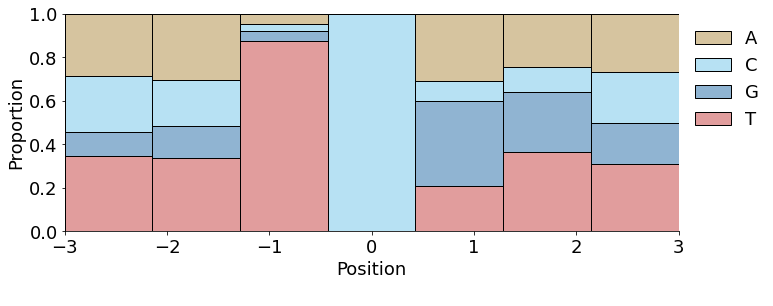

In [92]:
def get_heptamers_101(node_states):
    print("Count of node states:",len(node_states))
    heptamers = get_heptamers(node_states)
    print("Count of heptamers:",len(heptamers))
    make_heptamer_figure_101(heptamers)
get_heptamers_101(node_states)

Count of node states: 197209
57
Count of heptamers: 55


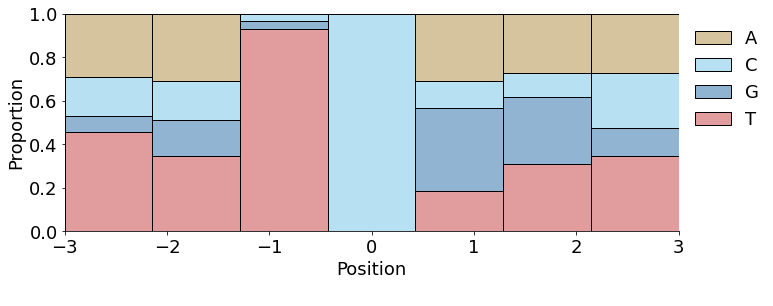

In [88]:
def get_backbone_heptamers(node_states):
    print("Count of node states:",len(node_states))
    heptamers = get_heptamers_backbone(node_states)
    print("Count of heptamers:",len(heptamers))
    make_heptamer_backbone_figure(heptamers)
    
get_backbone_heptamers(node_states)

In [79]:
def get_heptamers_general(node_states,branch_snps):
    site_dict = collections.defaultdict(list)
    snp_count = 0
    with open(branch_snps,"r") as f:
        reader = csv.DictReader(f)
        for row in reader:
            snp_count +=1
            if row["snp"] in ["G->A","C->T"]:
                site_dict[row["site"]] = (row["parent"],row["snp"])
    heptamers = []
    for site in site_dict:
        
        parent,dimer = site_dict[site]
#         print(site, parent, dimer)
        site = int(site)
        indexes = []
        bases = []
        for i in range(site-3,site+4):
            indexes.append(i)
            nodes = node_states[f"{i}"]
            base = ""
            for node in nodes:
                if node[0] == parent:
                    base = node[1]
            bases.append(base)
        seq = "".join(bases)
        
        seq = Seq(seq)
        
        if dimer == "G->A":
            
            seq = seq.reverse_complement()
        
        heptamers.append(seq)
    return snp_count,heptamers
              
def make_heptamer_figure(heptamers,hept_out,heptfigure):
    hept_dict = {}
    for i in range(7):
        hept_dict[i] = collections.Counter()

    rel_dict = {0:-3,1:-2,2:-1,3:0,4:1,5:2,6:3}
    mutations = 0

    with open(hept_out,"w") as fw:
        fw.write("position,rel_position,base\n")
        for heptamer in heptamers:
            hept_list = list(heptamer)

            for i in range(len(hept_list)):
                hept_dict[i][hept_list[i]] +=1 
                fw.write(f"{i+1},{rel_dict[i]},{hept_list[i]}\n")
                
#             for i in hept_dict:
#                 print(i, hept_dict[i])
                        
    df = pd.read_csv(hept_out)
    df
    fig,ax= plt.subplots(figsize=(11,4),facecolor='w',frameon=False)
    colors = {"A":"#4682B4",
              "C":"indianred",
              "G":"#BC9D60",
              "T":"#87CEEB"}
    
    colors = ["#BC9D60","#87CEEB","#4682B4","indianred"]
    customPalette = sns.set_palette(sns.color_palette(colors))

#     legend_elements = [Line2D([0], [0], markerfacecolor='#4682B4',color='white',markersize=15,alpha=0.6, marker='o',label='A'),
#                        Line2D([0], [0], markerfacecolor='indianred',color='white',markersize=15,alpha=0.6, marker='o',label='C'),
#                        Line2D([0], [0], markerfacecolor='#BC9D60',color='white',markersize=15, alpha=0.6,marker='o',label='G'),
#                         Line2D([0], [0], markerfacecolor='#87CEEB',color='white',markersize=15,alpha=0.6, marker='o',label='T')]

    g = sns.histplot(data=df, x="rel_position",hue="base",multiple="fill",hue_order = ['A','C','G','T'],palette=customPalette,alpha=0.6,bins=7,linewidth=1)

    sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1), frameon=False,title="")
    plt.xlim(-3,3)

    plt.xlabel("Position\n");
    plt.ylabel("Proportion")
    [ax.spines[loc].set_visible(False) for loc in ['top','right']]

    plt.savefig(f"figures/{heptfigure}.svg");
    plt.savefig(f"figures/{heptfigure}.png",bbox_inches='tight', 
                   transparent=True);
    plt.show();
    
def get_reconstruction_heptamers(directory, alignment,treefile,hept_out,heptamer_figure,width=35):
    node_states = get_node_states_all_sites(directory,f"{alignment}.state",alignment)
    print("Node states",len(node_states))
    branch_snps = f"{directory}/{treefile}.branch_snps.reconstruction.csv"
    snp_count,heptamers = get_heptamers_general(node_states,branch_snps)
    print("SNP count:",snp_count)
    print("Heptamer count:",len(heptamers))
    hept_out = f"{directory}/{hept_out}"
    hept_figure = f"{heptamer_figure}"
    make_heptamer_figure(heptamers,hept_out,hept_figure)
    

    

Node states 191655
SNP count: 1894
Heptamer count: 1238


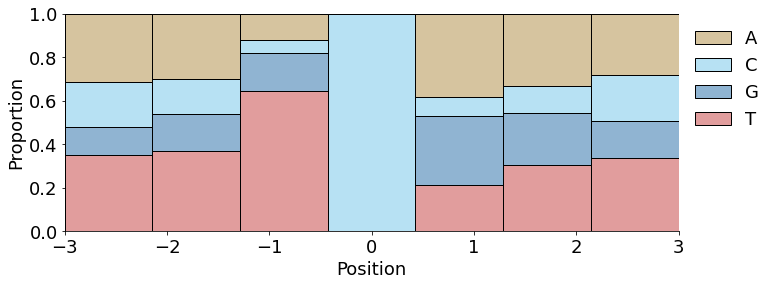

In [80]:
get_reconstruction_heptamers("variola_reconstruction", "variola_alignment.fasta","variola_alignment.fasta.pruned.tree","heptamer_composition.csv","variola_heptamers")


In [ ]:
get_reconstruction_heptamers("reconstruction_20220609","hMPXV_2022-06-09_101_genomes.aln.fasta",
                             "hMPXV_2022-06-09_101_genomes.fasta.pruned.tree"
                                "heptamer_composition.csv",
                                "heptamer_101_backbone")

## Root to tip analysis <a class="anchor" id="roottotip"></a>

In [112]:
def make_root_to_tip(directory,node_states,state_differences):
    metadata = get_acc_to_metadata_map("metadata/metadata.clades1-3.csv")
    
    with open(f"{directory}/{state_differences}","r") as f:
        
        reader = csv.DictReader(f) 
        header = reader.fieldnames
        year_dict = {}
        for col in header:
            if col in metadata:
                year = metadata[col]["year"]
                year_dict[col] = year
        apobec_counter = collections.Counter()
        for row in reader:
            for col in year_dict:
                if row["Node1"] in ["A","T","C","G"] and row[col] in ["A","T","C","G"]:
                    if row["Node1"] != row[col]:
                        site = row["site"]
                        snp = f'{row["Node1"]}->{row[col]}'
                        parent_name = "Node1"
                        parent_base = row["Node1"]
                        
                        if snp == "G->A":
                            dimer_site = f"{int(site)+1}"
                            dimer_base = ""

                            for i in node_states[dimer_site]:
                                if i[0] == parent_name:
                                    dimer_base = i[1]
                            dimer = f"{parent_base}{dimer_base}"
                        elif snp == "C->T":
                            dimer_site = f"{int(site)-1}"
                            dimer_base = ""

                            for i in node_states[dimer_site]:
                                if i[0] == parent_name:
                                    dimer_base = i[1]
                            dimer = f"{dimer_base}{parent_base}"
                        else:
                            dimer = ""
                        
                        if dimer in ["TC","GA"]:
                            apobec_counter[col]+=1
                            
        print(apobec_counter)
        x = []
        y = []
        for i in apobec_counter:
            if year_dict[i]:
                x.append(int(year_dict[i]))
                y.append(apobec_counter[i])
        return x,y
#         
            
        


Counter({'KJ642617': 58, 'KP849471': 10, 'JX878416': 9, 'JX878422': 9, 'AF380138': 9, 'HM172544': 9, 'JX878413': 8, 'JX878414': 8, 'JX878415': 8, 'JX878421': 8, 'JX878427': 8, 'JX878428': 8, 'KJ642618': 8, 'JX878409': 7, 'JX878411': 7, 'JX878412': 7, 'JX878425': 7, 'JX878429': 7, 'MT724770': 7, 'MT724772': 7, 'KJ642612': 7, 'JX878410': 6, 'JX878418': 6, 'JX878423': 6, 'KC257460': 6, 'KJ642613': 6, 'KP849469': 6, 'DQ011154': 5, 'DQ011155': 5, 'JX878407': 5, 'JX878408': 5, 'JX878419': 5, 'JX878420': 5, 'JX878424': 5, 'JX878426': 5, 'KJ642619': 5, 'JX878417': 1})
Counter({'KJ642617': 46, 'AY741551.1': 13, 'KJ642614.1': 12, 'KJ136820.1': 8, 'KP849470.1': 8, 'MN346702.1': 8, 'MN346703.1': 8, 'MT724769.1': 8, 'MN346690.1': 7, 'MN346691.1': 7, 'MN346692.1': 7, 'MN346693.1': 7, 'MN346694.1': 7, 'MN346695.1': 7, 'MN346696.1': 7, 'MN346697.1': 7, 'MN346698.1': 7, 'MN346699.1': 7, 'MN346700.1': 7, 'MN346701.1': 7, 'DQ011156.1': 6, 'KJ642616.1': 5, 'DQ011157.1': 2, 'MT903346.1': 2, 'MT903347.1': 2

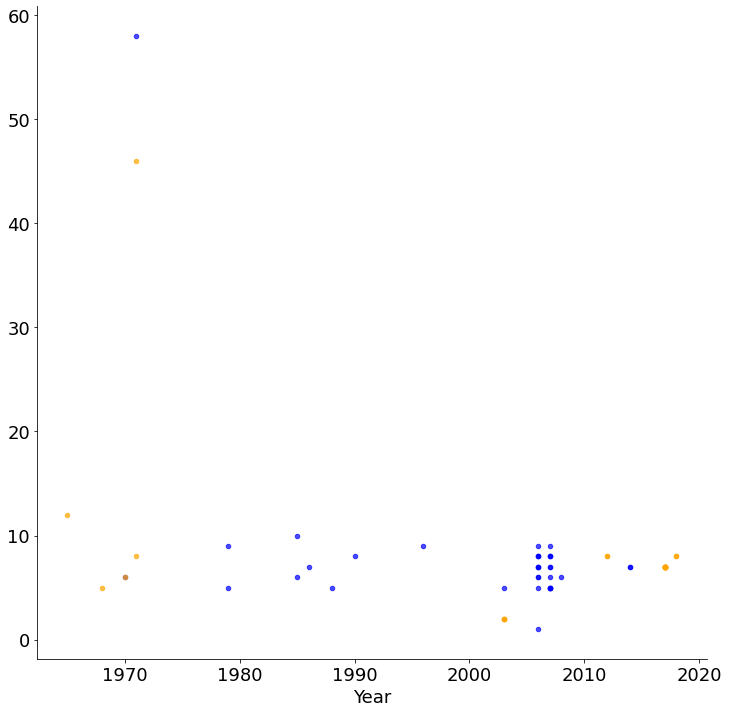

In [117]:
def make_c1c2_scatter():
    node_states = get_node_states_all_sites("reconstruction_clades1-3",f"clade1.fasta.state","clade1.fasta")
    x1,y1 = make_root_to_tip("reconstruction_clades1-3",node_states,"clade1.fasta.pruned.treefile.state_differences.csv")

    node_states = get_node_states_all_sites("reconstruction_clades1-3",f"clade2.fasta.state","clade2.fasta")
    x2,y2 = make_root_to_tip("reconstruction_clades1-3",node_states,"clade2.fasta.pruned.treefile.state_differences.csv")
    
    return x1,y1,x2,y2
    
       
    
x1,y1,x2,y2 = make_c1c2_scatter()
fig,ax= plt.subplots(figsize=(12,12),facecolor='w',frameon=False)
# sns.histplot(sites,  color="orange",alpha=0.2,bins=40,kde=True)
#     sns.kdeplot(sites, shade=True, bw=0.1, color="orange",alpha=0.2,cut=0)
plt.scatter(x1,y1,c="blue",alpha=0.7,s=20)
plt.scatter(x2,y2,c="orange",alpha=0.7,s=20)
[ax.spines[loc].set_visible(False) for loc in ['top','right']]

#     plt.xlim(0,197209)

plt.xlabel("Year")

plt.savefig("figures/root_to_tip.svg");
plt.savefig("figures/root_to_tip.png",bbox_inches='tight', 
           transparent=True);

In [9]:

def pull_out_codon(seq,position,index):
    codon = ""
    if position == 1:
        codon = seq[index:index+3]
    elif position == 2:
        codon = seq[index-1:index+2]
    elif position == 3:
        codon =  seq[index-2:index+1]
    return codon

def get_amino_acid_back_mutation(seq,type_counter,outfile):
    
    grantham_scores = get_grantham_scores()
    for i in range(len(seq)):
        base_1 = seq[i-1]
        base_2 = seq[i]
        
        site = f"{base_1}{base_2}"
        edited = "false"
        if site in ["TT","AA"]:
            
            #APOBEC TARGET SITES (do we want a count of apobec targeted sites? so TT and AA sites?)
            
                        
            if site =="AA":
                # relevant position is i-1
                position = get_aa_position(i-1)
                codon = pull_out_codon(seq,position,i-1)
                
                mutated_seq = str(seq[:i-1]) + "G" + str(seq[i:])
                mutated_seq = Seq(mutated_seq)
                mutated_codon = pull_out_codon(mutated_seq,position,i-1)
                

            elif site == "TT":

                position = get_aa_position(i)
                codon = pull_out_codon(seq,position,i)
                
                mutated_seq = str(seq)
                mutated_seq = str(seq[:i]) + "C" + str(seq[i+1:])

                mutated_seq = Seq(mutated_seq)
                mutated_codon = pull_out_codon(mutated_seq,position,i)
            
            aa = codon.translate()
            mutated_aa = mutated_codon.translate()
            
            mutation_category = ""
            if aa == mutated_aa:
                mutation_category = "synonymous"
            else:
                if codon in ["TGA","TAA","TAG"]:
                    mutation_category = "nonsense"
                else:
                    mutation_category = "nonsynonymous"

            type_counter[f"{mutation_category}"] +=1
            if f"{mutated_aa}{aa}" in grantham_scores:
                score = grantham_scores[f"{mutated_aa}{aa}"]
                if score < 51:
                    prediction = "conservative"
                elif score <101:
                    prediction = "moderately conservative"
                elif score <151:
                    prediction = "moderately radical"
                else:
                    prediction = "radical"
                    
            else:
                score = "NA"
                prediction = "NA"
            outfile.write(f"{position},{codon},{aa},{mutated_codon},{mutated_aa},{mutation_category},{score},{prediction}\n")
                

In [195]:
type_counter = collections.Counter()

with open("updated_aa_analysis/NC_063383.APOBEC_back_mutations.csv","w") as fw:
    fw.write(f"codon_position,codon,aa,mutated_codon,mutated_aa,mutation_category,score,prediction\n")

    for record in SeqIO.parse("/Users/s1680070/repositories/alignHPXV/squirrel/data/NC_063383.aln.cds.fasta","fasta"):
        seq = record.seq

        get_amino_acid_back_mutation(seq,type_counter,fw)

print(type_counter)


Counter({'nonsynonymous': 21613, 'synonymous': 11166, 'nonsense': 55})


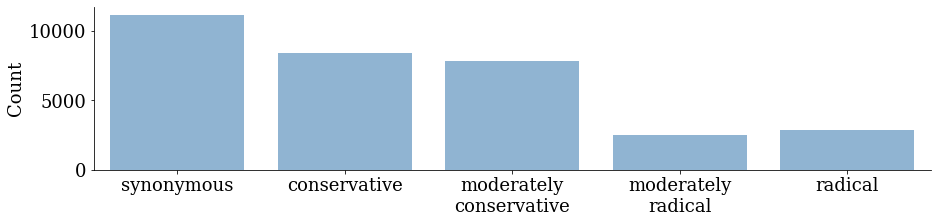

In [196]:
categories_not = collections.Counter()
with open("updated_aa_analysis/NC_063383.APOBEC_back_mutations.csv","r") as f:
    reader = csv.DictReader(f)
    for row in reader:
        if row["mutation_category"] == "nonsynonymous":
            categories_not[row["prediction"]] +=1
        else:
            categories_not[row["mutation_category"]] +=1
                
x = ["synonymous","conservative","moderately conservative","moderately radical","radical"]
y = [categories_not[i] for i in x]
fig,ax= plt.subplots(figsize=(15,3
                             ),facecolor='w',frameon=False)

bar1 = sns.barplot(x=x, y=y, alpha=0.6,facecolor="steelblue")
ax.set_xticklabels(["synonymous","conservative","moderately\nconservative","moderately\nradical","radical"])

[ax.spines[loc].set_visible(False) for loc in ['top','right']]
plt.xlabel("")
plt.ylabel("Count")
 
plt.savefig("figures/amino_acid_mutation_grantham_scores_back_mutated.NC_063383.svg");
plt.savefig("figures/amino_acid_mutation_grantham_scores_back_mutated.NC_063383.png",bbox_inches='tight', 
               transparent=True);

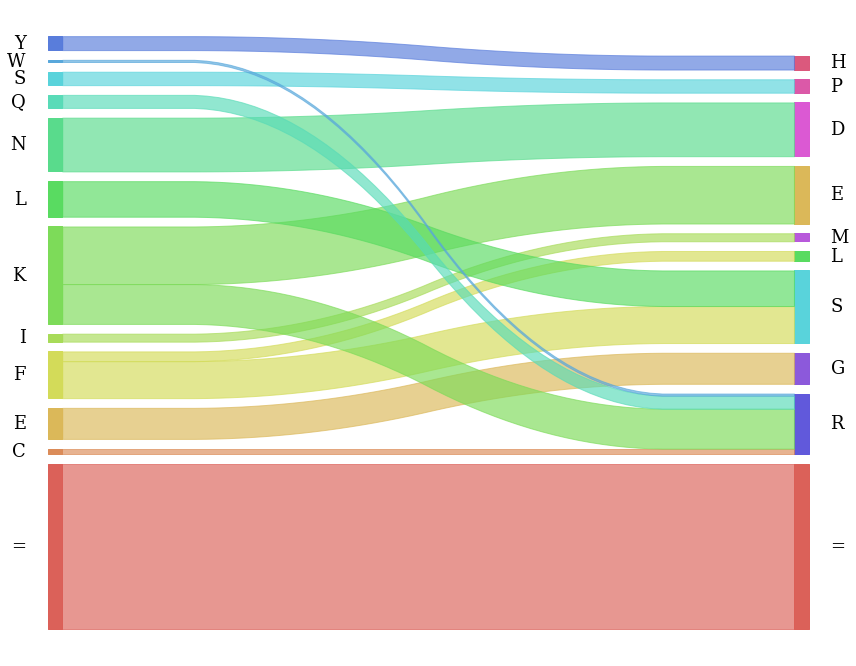

In [197]:

change_counter = collections.Counter()
with open("updated_aa_analysis/NC_063383.APOBEC_back_mutations.csv","r") as f:
    reader = csv.DictReader(f)
    for row in reader:
        if row["aa"] != row["mutated_aa"]:
            
            change = f"{row['aa']}{row['mutated_aa']}"
            if "*" not in change:
                change_counter[change] +=1
        else:
            change_counter["=="]+=1

with open("updated_aa_analysis/NC_063383.APOBEC_back_mutations.for_sankey.csv","w") as fw:
    fw.write("aa_before,aa_after,count\n")
    for change in sorted(change_counter, key=lambda x : x[0]):
#         print(change)
        fw.write(f"{change[0]},{change[1]},{change_counter[change]}\n")
df = pd.read_csv("updated_aa_analysis/NC_063383.APOBEC_back_mutations.for_sankey.csv")   

amino_acids = ["R","L","P","T","A","V","G","I","F","Y","C","H","Q","N","S","K","D","E","M","W","*"]

sankey(left=df["aa_before"],
       right=df["aa_after"],
       leftWeight=df["count"],
       rightWeight=df["count"],
#        aspect=0.1,
      fontsize=18)

fig = plt.gcf()
fig.set_size_inches(15, 12)
fig.set_facecolor("w")

# Save the figure
fig.savefig("figures/aa_changes_sankey.back_mutated.NC_063383.png", bbox_inches="tight", dpi=300,transparent=True)
fig.savefig("figures/aa_changes_sankey.back_mutated.NC_063383.svg",transparent=True)



In [11]:
def get_dimer_potential_mutation(seq,type_counter,outfile):
    positions = []
    grantham_scores = get_grantham_scores()
    for i in range(len(seq)):
        base_1 = seq[i-1]
        base_2 = seq[i]
        
        site = f"{base_1}{base_2}"
        edited = "false"
        if site in ["TC","GA"]:
            
            #APOBEC TARGET SITES (do we want a count of apobec targeted sites? so TT and AA sites?)
                      
            if site =="GA":
                # relevant position is i-1
                position = get_aa_position(i-1)
                codon = pull_out_codon(seq,position,i-1)
                
                mutated_seq = str(seq[:i-1]) + "A" + str(seq[i:])
                mutated_seq = Seq(mutated_seq)
                mutated_codon = pull_out_codon(mutated_seq,position,i-1)
                

            elif site == "TC":

                position = get_aa_position(i)
                codon = pull_out_codon(seq,position,i)
                
                mutated_seq = str(seq)
                mutated_seq = str(seq[:i]) + "T" + str(seq[i+1:])

                mutated_seq = Seq(mutated_seq)
                mutated_codon = pull_out_codon(mutated_seq,position,i)
                
            aa = codon.translate()
            mutated_aa = mutated_codon.translate()
            
            mutation_category = ""
            if aa == mutated_aa:
                mutation_category = "synonymous"
            else:
                if mutated_codon in ["TGA","TAA","TAG"]:
                    mutation_category = "nonsense"
                else:
                    mutation_category = "nonsynonymous"

            type_counter[f"{mutation_category}"] +=1
            if f"{aa}{mutated_aa}" in grantham_scores:
                score = grantham_scores[f"{mutated_aa}{aa}"]
                if score < 51:
                    prediction = "conservative"
                elif score <101:
                    prediction = "moderately conservative"
                elif score <151:
                    prediction = "moderately radical"
                else:
                    prediction = "radical"
                    
            else:
                score = "NA"
                prediction = "NA"

            outfile.write(f"{i},{position},{codon},{aa},{mutated_codon},{mutated_aa},{mutation_category},{score},{prediction}\n")
    return positions

def get_intergenic_dimer(seq,positions):
    intergenic_counter = 0
    print(len(positions))
    for i in range(len(seq)):
        base_1 = seq[i-1]
        base_2 = seq[i]
        
        site = f"{base_1}{base_2}"
        if site in ["TC","GA"]:
            
            #APOBEC TARGET SITES (do we want a count of apobec targeted sites? so TT and AA sites?)
            
                        
            if site =="GA":
                # relevant position is i-1
                position = get_aa_position(i-1)

            elif site == "TC":

                position = get_aa_position(i)
            
            if i not in positions:
                intergenic_counter +=1
                print(i)
    return intergenic_counter
                
            

In [12]:
type_counter = collections.Counter()
with open("updated_aa_analysis/NC_063383.APOBEC_forward_mutations.csv","w") as fw:
    fw.write(f"pos,codon_position,codon,aa,mutated_codon,mutated_aa,mutation_category,score,prediction\n")

    for record in SeqIO.parse("/Users/s1680070/repositories/alignHPXV/squirrel/data/NC_063383.aln.cds.fasta","fasta"):
        seq = record.seq
#         print(record.id)
        get_dimer_potential_mutation(seq,type_counter,fw)
        
print(type_counter)

Counter({'nonsynonymous': 14672, 'synonymous': 5024, 'nonsense': 693})


In [265]:
# type_counter = collections.Counter()


# with open("updated_aa_analysis/NC_063383.APOBEC_forward_mutations.csv","w") as fw:
#     fw.write(f"codon_position,codon,aa,mutated_codon,mutated_aa,mutation_category,score,prediction\n")

#     for record in SeqIO.parse("/Users/s1680070/repositories/alignHPXV/squirrel/data/NC_063383.aln.cds.fasta","fasta"):
#         seq = record.seq

#         positions = get_dimer_potential_mutation(seq,type_counter,fw)
# #     for record in SeqIO.parse("/Users/s1680070/repositories/alignHPXV/squirrel/data/NC_063383.aln.fasta","fasta"):
# #         all_seq = record.seq

# #         intergenic_target_counts = get_intergenic_dimer(all_seq,positions)
# print(type_counter)
# print(intergenic_target_counts)

total_not_edited = sum(type_counter.values())
print(total_not_edited)
with open("updated_B1_2022-07-14/whole_dataset/hMPXV1_393.aln.fasta.pruned.tree.amino_acid.reconstruction.csv","r") as f:
    with open("updated_B1_2022-07-14/whole_dataset/NC_063383_forward_vs_APOBEC_observed.counts.csv","w") as fw:
        fw.write("type,status,count,proportion\n")
        for t in type_counter:

            count = type_counter[t]

            prop = round(count/total_not_edited, 2)

            fw.write(f"{t},target,{count},{prop}\n")
#         prop = round(intergenic_target_counts/total_not_edited, 2)
#         fw.write(f"intergenic,target,{intergenic_target_counts},{prop}\n")

        reader = csv.DictReader(f)
        counter = collections.Counter()
        for row in reader:
            if row["apobec"] =="True":
                branch = [row["parent"],row["child"]]
                if row["child"].startswith("Node"):
                    if branch != ["Node1","Node2"] and row["mutation_category"]!= "intergenic":
                        counter[row["mutation_category"]]+=1
        
        total_edited = sum(counter.values())
        print(total_edited)
        for t in counter:
            count = counter[t]
            prop = round(count/total_edited, 2)
            fw.write(f"{t},observed,{count},{prop}\n")
            print(t, count)
                



20389
116
nonsynonymous 63
synonymous 46
nonsense 7


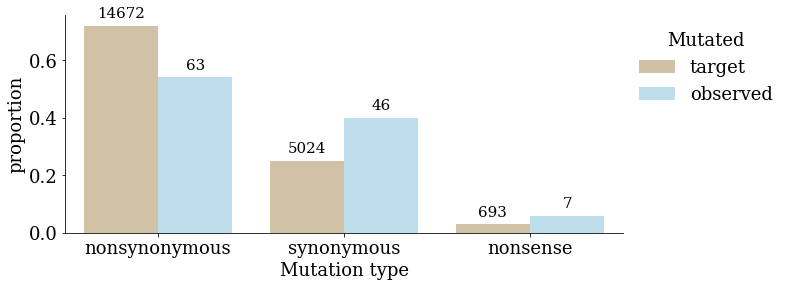

In [267]:
df = pd.read_csv("updated_B1_2022-07-14/whole_dataset/NC_063383_forward_vs_APOBEC_observed.counts.csv")
df
fig,ax= plt.subplots(figsize=(10,4),facecolor='w',frameon=False)
# df = df.sort_values('position').reset_index()
# Counter({'nonsynonymous': 14672, 'synonymous': 5024, 'nonsense': 693})

bar1 = sns.barplot(x=df["type"],  y=df["proportion"], hue=df["status"], alpha=0.6)
bar_label = [14672,5024,693,63,46,7]
bar_index = 0
for p in bar1.patches:
    
    bar1.annotate(bar_label[bar_index], 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   size=15,
                   xytext = (0, 12), 
                   textcoords = 'offset points')
    bar_index+=1
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1), frameon=False,title="Mutated")
[ax.spines[loc].set_visible(False) for loc in ['top','right']]
plt.xlabel("Mutation type")
    
plt.savefig("figures/observed_APOBEC_393_vs_APOBEC_target_sites_left.svg");
plt.savefig("figures/observed_APOBEC_393_vs_APOBEC_target_sites_left.png",bbox_inches='tight', 
               transparent=True);

plt.show();

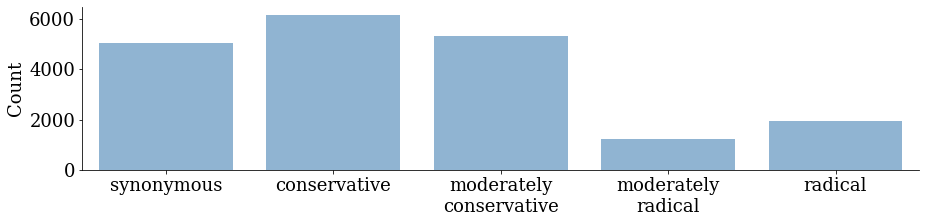

In [273]:
categories_not = collections.Counter()
with open("updated_aa_analysis/NC_063383.APOBEC_forward_mutations.csv","r") as f:
    reader = csv.DictReader(f)
    for row in reader:
        if row["mutation_category"] == "nonsynonymous":
            categories_not[row["prediction"]] +=1
        else:
            categories_not[row["mutation_category"]] +=1
                
x = ["synonymous","conservative","moderately conservative","moderately radical","radical"]
y = [categories_not[i] for i in x]
fig,ax= plt.subplots(figsize=(15,3
                             ),facecolor='w',frameon=False)

bar1 = sns.barplot(x=x, y=y, alpha=0.6,facecolor="steelblue")
ax.set_xticklabels(["synonymous","conservative","moderately\nconservative","moderately\nradical","radical"])

[ax.spines[loc].set_visible(False) for loc in ['top','right']]
plt.xlabel("")
plt.ylabel("Count")
 
plt.savefig("figures/amino_acid_mutation_grantham_scores_forward_mutated.NC_063383.svg");
plt.savefig("figures/amino_acid_mutation_grantham_scores_forward_mutated.NC_063383.png",bbox_inches='tight', 
               transparent=True);